# Prepare datadests

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import frogress
import numpy as np
import healpy as hp
import math
import copy
def IndexToDeclRa(index, nside,nest= False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest=nest)
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)



def g2k_sphere(gamma1, gamma2, mask, nside=1024, lmax=2048,nosh=True):
    """
    Convert shear to convergence on a sphere. In put are all healpix maps.
    """

    gamma1_mask = gamma1 * mask
    gamma2_mask = gamma2 * mask

    KQU_masked_maps = [gamma1_mask, gamma1_mask, gamma2_mask]
    alms = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True)  # Spin transform!


    ell, emm = hp.Alm.getlm(lmax=lmax)
    if nosh:
        almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
        almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
    else:
        almsE = alms[1] * 1.
        almsB = alms[2] * 1. 
    almsE[ell == 0] = 0.0
    almsB[ell == 0] = 0.0
    almsE[ell == 1] = 0.0
    almsB[ell == 1] = 0.0



    almssm = [alms[0], almsE, almsB]


    kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False)
    E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False)
    B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False)

    return E_map, B_map, almsE


def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute

'''
The DarkGrid simulation shave no systematics, and only vary Omega_m and sigma_8.
There are 285 independent full sky simulations.
'''
path = '/global/cfs/cdirs/des/mgatti/darkgrid_nosyst_kappa/'
nside = 512 #nside of the maps
nside_crop = 2
pixel = 512 # number of pixels of the projected stamps
res = hp.nside2resol(nside, arcmin=True)

Area_patch = res*res*pixel*pixel/3600
print ('AREA PATCH {0:2.0f} deg^2'.format(Area_patch))


'''
I want to test different survey areas and different number density, to check the scaling of the constraining power
and test if we're overfitting
'''

FOOTPRINTS = {
    "DESY3": 4143, # DESY3 Gatti et al. 2020
    "LSSTY1": 12300, # LSST DESC SRD
    "LSSTY10": 14300, # LSST DESC SRD
    "infinite": 14300, # LSST DESC SRD
}

DEN_GAL = {
    "DESY3": 5.59 * res * res, # DESY3 Gatti et al. 2020
    "LSSTY1": 11.112 * res * res, # LSST DESC SRD
    "LSSTY10": 27.737 * res * res, # LSST DESC SRD
    "infinite": 100000000, # LSST DESC SRD
}


SHAPE_NOISE = 0.26

NUMBER_PATCHES = {}
for k in FOOTPRINTS.keys():
    NUMBER_PATCHES[k] = math.ceil(FOOTPRINTS[k]/Area_patch)
    


map_indexes = np.arange(hp.nside2npix(nside_crop))
dec_,ra_ = IndexToDeclRa(map_indexes,nside_crop,nest=False)
pairs_ = np.vstack([ra_,dec_]).T

print (len(pairs_))

AREA PATCH 3438 deg^2
48


In [2]:
'''
Given nside_crop = 2, there are at most 48 independent patches from a given full-sky map.
This next loop saves those 48 patches. You can also run python prepare_data.py - it will do the same as the following snippet but in parallel, so it will be much faster.
This code also adds shape noise to the four tomographic bins.
'''

import timeit

for rel in range(285):
    params = []
    patches_to_save = {}
    for LABEL in NUMBER_PATCHES.keys():
        patches_to_save[LABEL] = dict()
        patches_to_save[LABEL][1] = []
        patches_to_save[LABEL][2] = []
        patches_to_save[LABEL][3] = []
        patches_to_save[LABEL][4] = []

    st = timeit.default_timer()
    m = np.load(path+'{0}_noiserel_0.npy'.format(rel),allow_pickle=True).item()
    om,s8 = m[0]['config']['Om'],m[0]['config']['sigma8']
    for t in [1,2,3,4]:

        g1 = m[0]['g1'][t]
        g2 = m[0]['g2'][t]

        k,_,_ = g2k_sphere(g1, g2, g1==g1, nside=nside, lmax=nside*3-1,nosh=True)
        patches = [np.array(hp.gnomview(k, rot=(pairs_[i][0],pairs_[i][1]), xsize=pixel ,no_plot=True,reso=res,return_projected_map=True)) for i in range(len(pairs_))]

        for LABEL in NUMBER_PATCHES.keys():
            patches_ = copy.deepcopy(patches)
            for i in range(len(patches)):
                patches_[i] = patches[i] + np.random.normal(0, SHAPE_NOISE / np.sqrt(DEN_GAL[LABEL] / 4), (pixel,pixel))
                patches_to_save[LABEL][t].append(patches_[i])

    params.append([om,s8])

        # Add noise -------
    end = timeit.default_timer()
    np.save('/global/cfs/cdirs/des/mgatti/VIT_data_515/{0}'.format(rel),[patches_to_save,params])

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


KeyboardInterrupt: 

# prepare data (2)

In [ ]:
'''
This next snippet reads the 48x4 patches of all the sims, and re-arrange them into different files depending on the types of analyses (DES/LSSTY1/ etc...)
we want to perform. I am using the first 10 patches for the training (the networks will have 10x285 = 2850 patches for the training).
We will use the remaining up to 4x285 for the LFI part, depending on the survey size (DES Y3 will use 1 patch, LSST Y1 3 patches, LSST Y10 4 patches)
'''
import numpy as np

# Assuming NUMBER_PATCHES is defined somewhere in your code.
channel = 4

training_patches = 2
lfi_patches  = 4 # this needs to be AT LEAST 4 for 512x512 patches, such that to cover the lssty10 area


# Initialize storage structures outside the rel loop
training_data = {LABEL: {k: [] for k in range(1, 5)} for LABEL in NUMBER_PATCHES.keys()}
LFI_data = {LABEL: {k: [] for k in range(1, 5)} for LABEL in NUMBER_PATCHES.keys()}
training_params = {LABEL: [] for LABEL in NUMBER_PATCHES.keys()}
LFI_params = {LABEL: [] for LABEL in NUMBER_PATCHES.keys()}

# First loop through each file
for rel in (range(285)):
    # Load the data once for each file
    [patches_to_save_, params_] = np.load(f'/global/cfs/cdirs/des/mgatti/VIT_data_512/{rel}.npy', allow_pickle=True)
    
    # Then, for each label, select and store the appropriate data
    for LABEL in NUMBER_PATCHES.keys():
        idx_training = np.random.choice(range(len(patches_to_save_[LABEL][1])), training_patches, replace=False)
        idx_LFI = np.random.choice(range(len(patches_to_save_[LABEL][1])), lfi_patches, replace=False)

        # Append selected data for training
        for i in idx_training:
            for k in range(1, 5):
                if channel != 1 or k == 3:  # Adjust this condition as per your requirement
                    training_data[LABEL][k].append(patches_to_save_[LABEL][k][i])
            training_params[LABEL].append(params_[0])
        
        # Append selected data for LFI
        for i in idx_LFI:
            for k in range(1, 5):
                if channel != 1 or k == 3:  # Adjust this condition as per your requirement
                    LFI_data[LABEL][k].append(patches_to_save_[LABEL][k][i])
            LFI_params[LABEL].append(params_[0])

# After collecting all data, save it
for LABEL in NUMBER_PATCHES.keys():
    if channel == 1:
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_512/training/{LABEL}_{channel}', [training_data[LABEL], training_params[LABEL]])
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_512/LFI/{LABEL}_{channel}', [LFI_data[LABEL], LFI_params[LABEL]])
    else:
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_512/training/{LABEL}', [training_data[LABEL], training_params[LABEL]])
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_512/LFI/{LABEL}', [LFI_data[LABEL], LFI_params[LABEL]])

  2.1% | [..........] | Progress: 6 / 285 | Time: 5.5s | ETA: 4min18s

In [4]:
import numpy as np
import frogress


training_patches = 20
lfi_patches  = 22 # this needs to be AT LEAST 22 for 224x224 patches, such that to cover the lssty10 area
# Assuming NUMBER_PATCHES is defined somewhere in your code.
channel = 4

# Initialize storage structures outside the rel loop
training_data = {LABEL: {k: [] for k in range(1, 5)} for LABEL in NUMBER_PATCHES.keys()}
LFI_data = {LABEL: {k: [] for k in range(1, 5)} for LABEL in NUMBER_PATCHES.keys()}
training_params = {LABEL: [] for LABEL in NUMBER_PATCHES.keys()}
LFI_params = {LABEL: [] for LABEL in NUMBER_PATCHES.keys()}

# First loop through each file
for rel in (range(285)):
    # Load the data once for each file
    [patches_to_save_, params_] = np.load(f'/global/cfs/cdirs/des/mgatti/VIT_data_224/{rel}.npy', allow_pickle=True)
    
    # Then, for each label, select and store the appropriate data
    for LABEL in NUMBER_PATCHES.keys():
        idx_training = np.random.choice(range(len(patches_to_save_[LABEL][1])), training_patches, replace=False)
        idx_LFI = np.random.choice(range(len(patches_to_save_[LABEL][1])), lfi_patches, replace=False)

        # Append selected data for training
        for i in idx_training:
            for k in range(1, 5):
                if channel != 1 or k == 3:  # Adjust this condition as per your requirement
                    training_data[LABEL][k].append(patches_to_save_[LABEL][k][i])
            training_params[LABEL].append(params_[0])
        
        # Append selected data for LFI
        for i in idx_LFI:
            for k in range(1, 5):
                if channel != 1 or k == 3:  # Adjust this condition as per your requirement
                    LFI_data[LABEL][k].append(patches_to_save_[LABEL][k][i])
            LFI_params[LABEL].append(params_[0])

# After collecting all data, save it
for LABEL in NUMBER_PATCHES.keys():
    if channel == 1:
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_224/training/{LABEL}_{channel}', [training_data[LABEL], training_params[LABEL]])
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_224/LFI/{LABEL}_{channel}', [LFI_data[LABEL], LFI_params[LABEL]])
    else:
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_224/training/{LABEL}', [training_data[LABEL], training_params[LABEL]])
        np.save(f'/global/cfs/cdirs/des/mgatti/VIT_data_224/LFI/{LABEL}', [LFI_data[LABEL], LFI_params[LABEL]])

100.0% | [##########] | Progress: 285 / 285 | Time: 2min42s | ETA: --0ssss

# Resnet

In [ ]:
channels = 4
size_patches = 512 # 512

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


def modify_resnet_for_regression(num_channels=channels):
    # Load a pre-trained ResNet model. You can choose from models like resnet18, resnet34, resnet50, etc.
    model = models.resnet18(pretrained=False)
    
    # Original first layer: nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    original_first_layer = model.conv1
    new_first_layer = nn.Conv2d(num_channels, 
                                original_first_layer.out_channels, 
                                kernel_size=(7,7), 
                                stride=original_first_layer.stride, 
                                padding=original_first_layer.padding, 
                                bias=original_first_layer.bias)
    
    # Copy the weights from the original first layer to the new layer
    # The weights for the first three channels will be copied directly, the weights for the fourth channel
    # will be initialized as zeros or you can average the weights of the first three channels.
    with torch.no_grad():
        if num_channels == 3:
            # If num_channels is 3, directly copy the weights from the original layer
            new_first_layer.weight[:] = original_first_layer.weight
        else:
            # For a different number of channels, average the original weights or apply other logic
            # Here we're averaging across the channel dimension of the original weights
            # This creates a [out_channels, 1, kernel_height, kernel_width] tensor
            averaged_weights = original_first_layer.weight.mean(dim=1, keepdim=True)
            # Repeat this averaged weight tensor 'num_channels' times along the channel dimension
            new_first_layer.weight[:, :num_channels] = averaged_weights.repeat(1, num_channels, 1, 1)
    
    # Replace the first convolutional layer with the new one
    model.conv1 = new_first_layer
    
    # Adjust the output layer for regression (output a single value)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # Change the final layer to output a single value
    
    return model
    

    
    


/global/common/software/nersc/pm-2022q4/sw/pytorch/2.0.1/lib/python3.9/site-packages/torchvision-0.15.2a0+fa99a53-py3.9-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/global/common/software/nersc/pm-2022q4/sw/pytorch/2.0.1/lib/python3.9/site-packages/torchvision-0.15.2a0+fa99a53-py3.9-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/100, Loss: 4.0825, Validation Loss: 6705.2490
Epoch 2/100, Loss: 0.2355, Validation Loss: 0.4455
Epoch 3/100, Loss: 0.0404, Validation Loss: 0.0594
Epoch 4/100, Loss: 0.0192, Validation Loss: 0.1705
Epoch 5/100, Loss: 0.0125, Validation Loss: 0.8445
Epoch 6/100, Loss: 0.0076, Validation Loss: 1.1438
Epoch 7/100, Loss: 0.0073, Validation Loss: 1.2412
Epoch 8/100, Loss: 0.0051, Validation Loss: 0.4521
Epoch 9/100, Loss: 0.0053, Validation Loss: 0.0162
Epoch 10/100, Loss: 0.0049, Validation Loss: 0.0053
Epoch 11/100, Loss: 0.0046, Validation Loss: 0.0042
Epoch 12/100, Loss: 0.0057, Validation Loss: 0.0045
Epoch 13/100, Loss: 0.0067, Validation Loss: 0.0042
Epoch 14/100, Loss: 0.0044, Validation Loss: 0.0046
Epoch 15/100, Loss: 0.0037, Validation Loss: 0.0035
Epoch 16/100, Loss: 0.0039, Validation Loss: 0.0053
Epoch 17/100, Loss: 0.0041, Validation Loss: 0.0044
Epoch 18/100, Loss: 0.0031, Validation Loss: 0.0054
Epoch 19/100, Loss: 0.0029, Validation Loss: 0.0039
Epoch 20/100, Loss

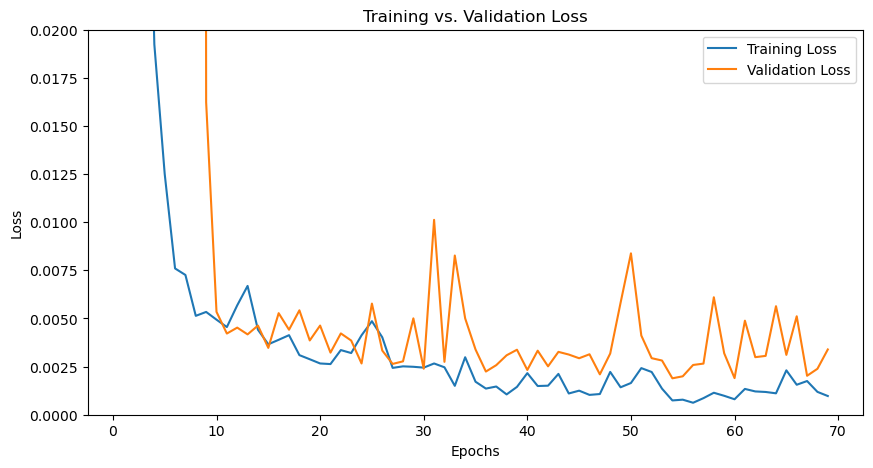

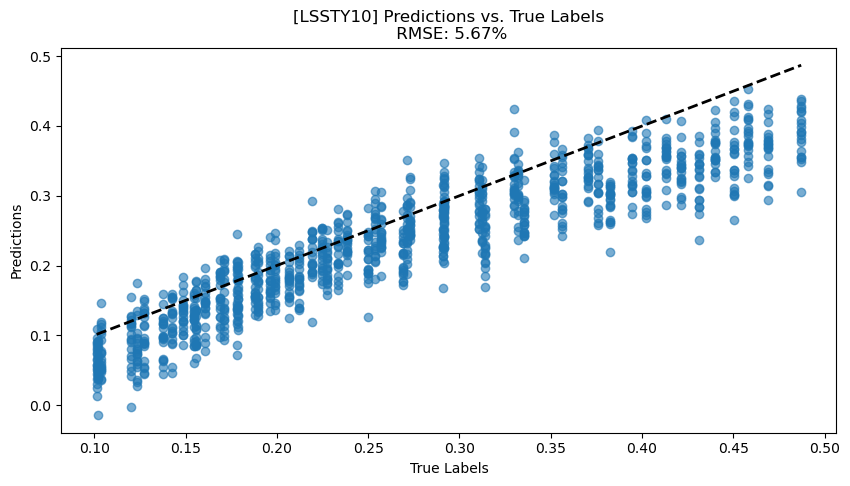

Epoch 1/100, Loss: 3.6018, Validation Loss: 180.8265
Epoch 2/100, Loss: 0.0296, Validation Loss: 0.1268
Epoch 3/100, Loss: 0.0120, Validation Loss: 0.9617
Epoch 4/100, Loss: 0.0052, Validation Loss: 0.0276
Epoch 5/100, Loss: 0.0037, Validation Loss: 0.0329
Epoch 6/100, Loss: 0.0023, Validation Loss: 0.1080
Epoch 7/100, Loss: 0.0024, Validation Loss: 0.3213
Epoch 8/100, Loss: 0.0021, Validation Loss: 0.2780
Epoch 9/100, Loss: 0.0027, Validation Loss: 0.0271
Epoch 10/100, Loss: 0.0051, Validation Loss: 0.0080
Epoch 11/100, Loss: 0.0047, Validation Loss: 0.0041
Epoch 12/100, Loss: 0.0040, Validation Loss: 0.0012
Epoch 13/100, Loss: 0.0015, Validation Loss: 0.0011
Epoch 14/100, Loss: 0.0012, Validation Loss: 0.0011
Epoch 15/100, Loss: 0.0018, Validation Loss: 0.0020
Epoch 16/100, Loss: 0.0012, Validation Loss: 0.0009
Epoch 17/100, Loss: 0.0017, Validation Loss: 0.0008
Epoch 18/100, Loss: 0.0019, Validation Loss: 0.0018
Epoch 19/100, Loss: 0.0022, Validation Loss: 0.0008
Epoch 20/100, Loss:

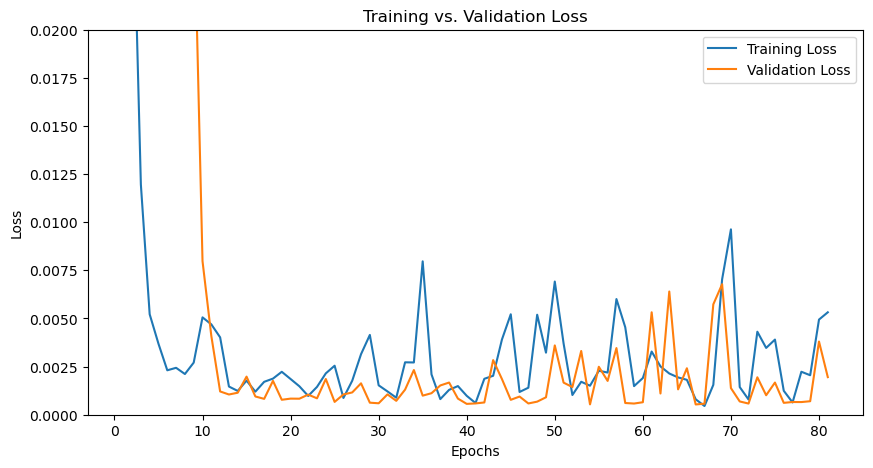

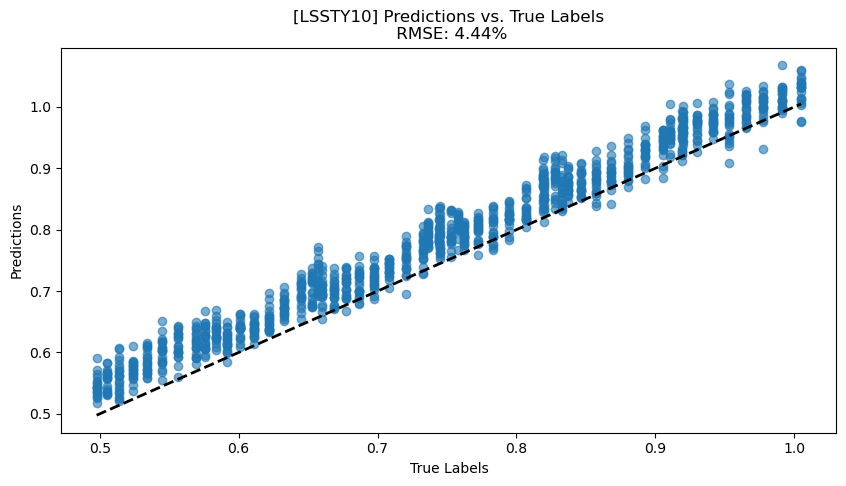

Epoch 1/100, Loss: 1.5637, Validation Loss: 895.9699
Epoch 2/100, Loss: 0.4619, Validation Loss: 2.8767
Epoch 3/100, Loss: 0.0237, Validation Loss: 3.2822
Epoch 4/100, Loss: 0.0093, Validation Loss: 1.6181
Epoch 5/100, Loss: 0.0058, Validation Loss: 1.4777
Epoch 6/100, Loss: 0.0040, Validation Loss: 1.7628
Epoch 7/100, Loss: 0.0030, Validation Loss: 1.6092
Epoch 8/100, Loss: 0.0024, Validation Loss: 0.3593
Epoch 9/100, Loss: 0.0020, Validation Loss: 0.0291
Epoch 10/100, Loss: 0.0031, Validation Loss: 0.0130
Epoch 11/100, Loss: 0.0030, Validation Loss: 0.0079
Epoch 12/100, Loss: 0.0011, Validation Loss: 0.0070
Epoch 13/100, Loss: 0.0022, Validation Loss: 0.0076
Epoch 14/100, Loss: 0.0019, Validation Loss: 0.0075
Epoch 15/100, Loss: 0.0004, Validation Loss: 0.0070
Epoch 16/100, Loss: 0.0006, Validation Loss: 0.0071
Epoch 17/100, Loss: 0.0005, Validation Loss: 0.0071
Epoch 18/100, Loss: 0.0019, Validation Loss: 0.0085
Epoch 19/100, Loss: 0.0017, Validation Loss: 0.0080
Epoch 20/100, Loss:

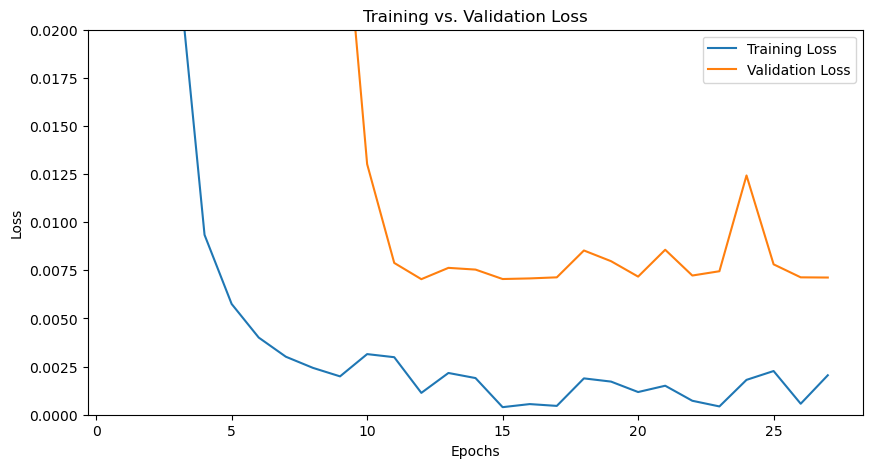

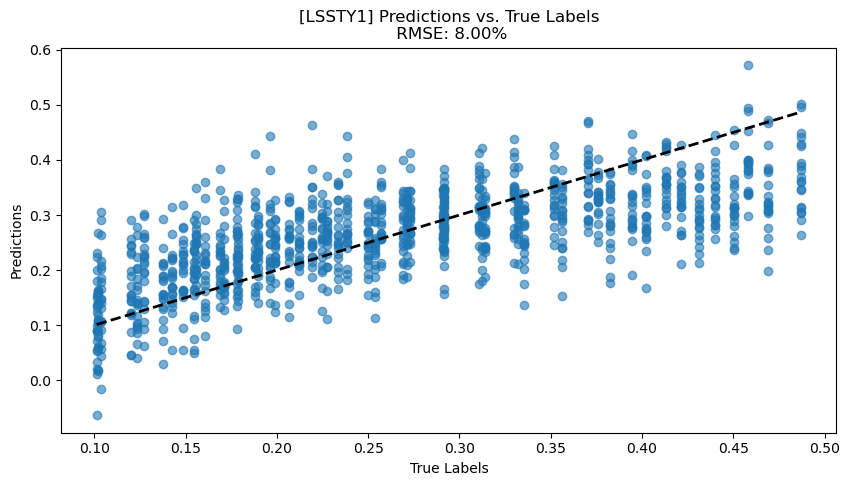

Epoch 1/100, Loss: 2.5485, Validation Loss: 779.5574
Epoch 2/100, Loss: 0.2449, Validation Loss: 28.0988
Epoch 3/100, Loss: 0.0143, Validation Loss: 0.0193
Epoch 4/100, Loss: 0.0041, Validation Loss: 0.0590
Epoch 5/100, Loss: 0.0018, Validation Loss: 0.0681
Epoch 6/100, Loss: 0.0013, Validation Loss: 0.5026
Epoch 7/100, Loss: 0.0010, Validation Loss: 1.6889
Epoch 8/100, Loss: 0.0010, Validation Loss: 1.0963
Epoch 9/100, Loss: 0.0015, Validation Loss: 0.1103
Epoch 10/100, Loss: 0.0020, Validation Loss: 0.0033
Epoch 11/100, Loss: 0.0006, Validation Loss: 0.0066
Epoch 12/100, Loss: 0.0039, Validation Loss: 0.0028
Epoch 13/100, Loss: 0.0032, Validation Loss: 0.0016
Epoch 14/100, Loss: 0.0014, Validation Loss: 0.0061
Epoch 15/100, Loss: 0.0028, Validation Loss: 0.0025
Epoch 16/100, Loss: 0.0024, Validation Loss: 0.0017
Epoch 17/100, Loss: 0.0026, Validation Loss: 0.0016
Epoch 18/100, Loss: 0.0011, Validation Loss: 0.0017
Epoch 19/100, Loss: 0.0015, Validation Loss: 0.0044
Epoch 20/100, Loss

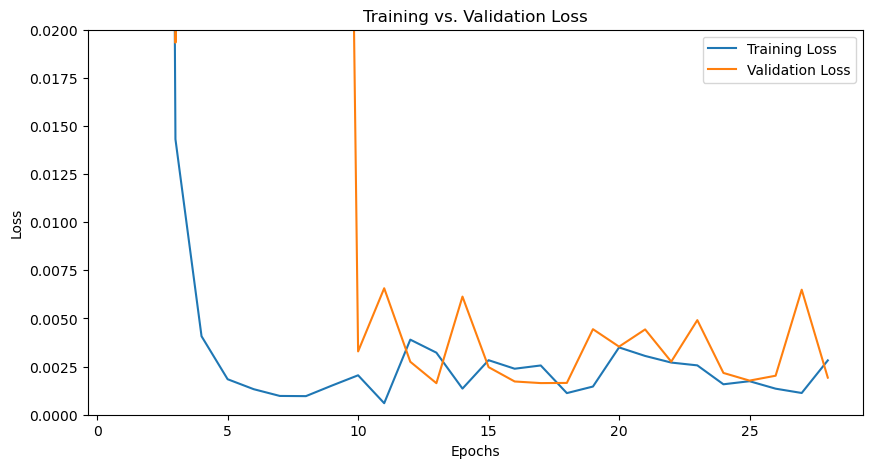

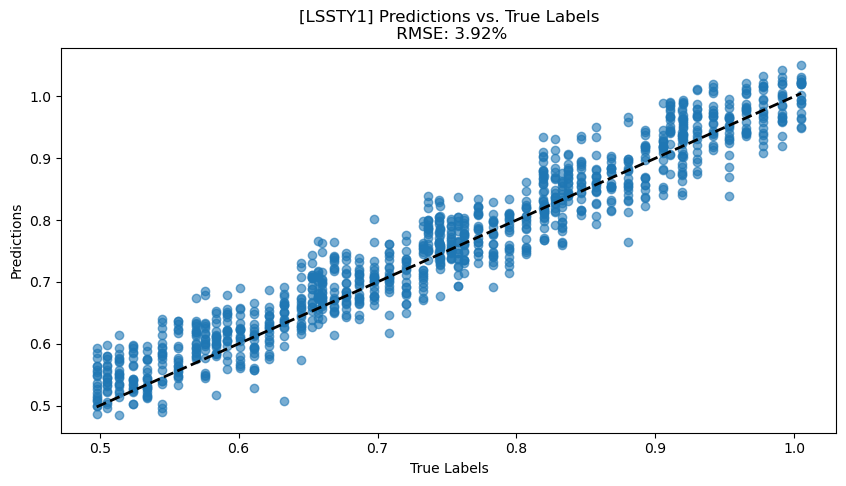

Epoch 1/100, Loss: 0.4236, Validation Loss: 21.9361
Epoch 2/100, Loss: 0.0203, Validation Loss: 9.6575
Epoch 3/100, Loss: 0.0085, Validation Loss: 0.8968
Epoch 4/100, Loss: 0.0014, Validation Loss: 0.4901
Epoch 5/100, Loss: 0.0016, Validation Loss: 0.0859
Epoch 6/100, Loss: 0.0016, Validation Loss: 0.0143
Epoch 7/100, Loss: 0.0016, Validation Loss: 0.0403
Epoch 8/100, Loss: 0.0006, Validation Loss: 0.0220
Epoch 9/100, Loss: 0.0019, Validation Loss: 0.0170
Epoch 10/100, Loss: 0.0007, Validation Loss: 0.0131
Epoch 11/100, Loss: 0.0011, Validation Loss: 0.0161
Epoch 12/100, Loss: 0.0019, Validation Loss: 0.0130
Epoch 13/100, Loss: 0.0035, Validation Loss: 0.0121
Epoch 14/100, Loss: 0.0020, Validation Loss: 0.0123
Epoch 15/100, Loss: 0.0012, Validation Loss: 0.0124
Epoch 16/100, Loss: 0.0012, Validation Loss: 0.0122
Epoch 17/100, Loss: 0.0013, Validation Loss: 0.0118
Epoch 18/100, Loss: 0.0010, Validation Loss: 0.0130
Epoch 19/100, Loss: 0.0016, Validation Loss: 0.0142
Epoch 20/100, Loss: 

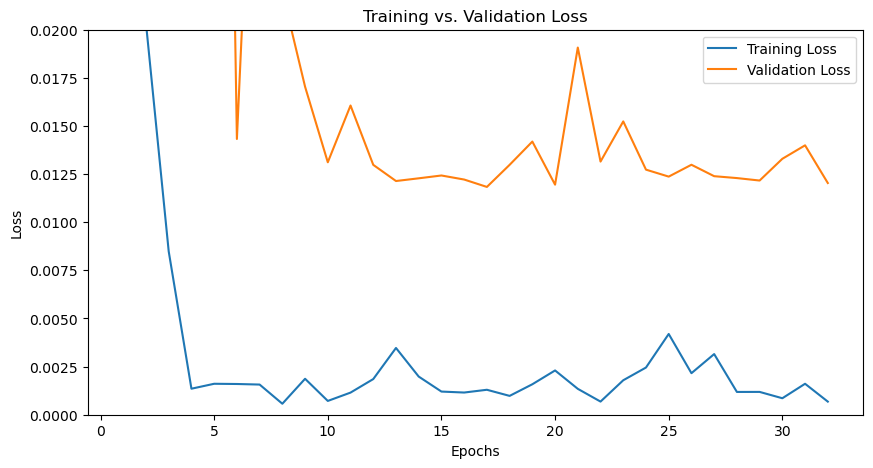

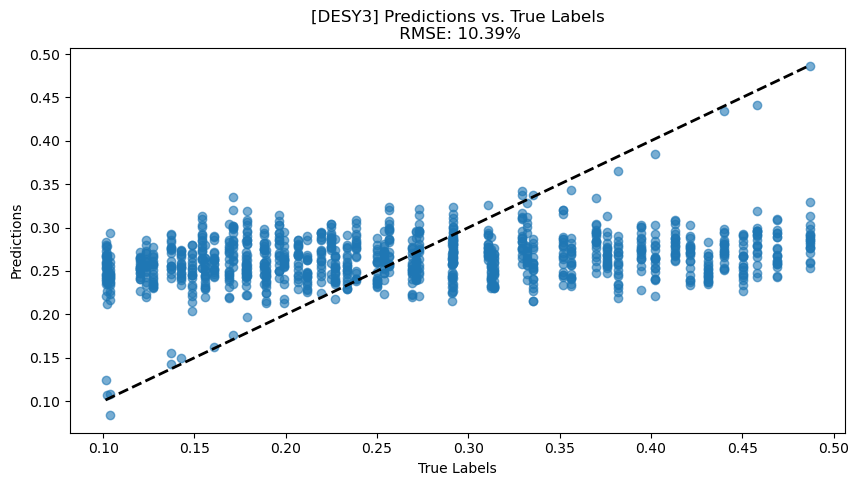

Epoch 1/100, Loss: 0.2648, Validation Loss: 0.0191
Epoch 2/100, Loss: 0.1995, Validation Loss: 0.0451
Epoch 3/100, Loss: 0.0118, Validation Loss: 0.5604
Epoch 4/100, Loss: 0.0040, Validation Loss: 0.1375
Epoch 5/100, Loss: 0.0030, Validation Loss: 0.0366
Epoch 6/100, Loss: 0.0014, Validation Loss: 0.0545
Epoch 7/100, Loss: 0.0027, Validation Loss: 1.9836
Epoch 8/100, Loss: 0.0022, Validation Loss: 0.5981
Epoch 9/100, Loss: 0.0024, Validation Loss: 0.0551
Epoch 10/100, Loss: 0.0038, Validation Loss: 0.0104
Epoch 11/100, Loss: 0.0026, Validation Loss: 0.0016
Epoch 12/100, Loss: 0.0016, Validation Loss: 0.0015
Epoch 13/100, Loss: 0.0015, Validation Loss: 0.0026
Epoch 14/100, Loss: 0.0035, Validation Loss: 0.0052
Epoch 15/100, Loss: 0.0025, Validation Loss: 0.0031
Epoch 16/100, Loss: 0.0056, Validation Loss: 0.0120
Epoch 17/100, Loss: 0.0059, Validation Loss: 0.0099
Epoch 18/100, Loss: 0.0054, Validation Loss: 0.0024
Epoch 19/100, Loss: 0.0007, Validation Loss: 0.0039
Epoch 20/100, Loss: 0

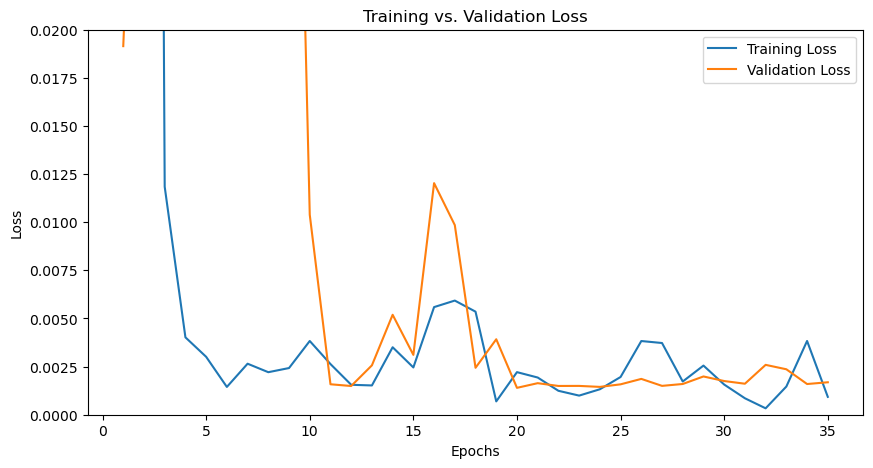

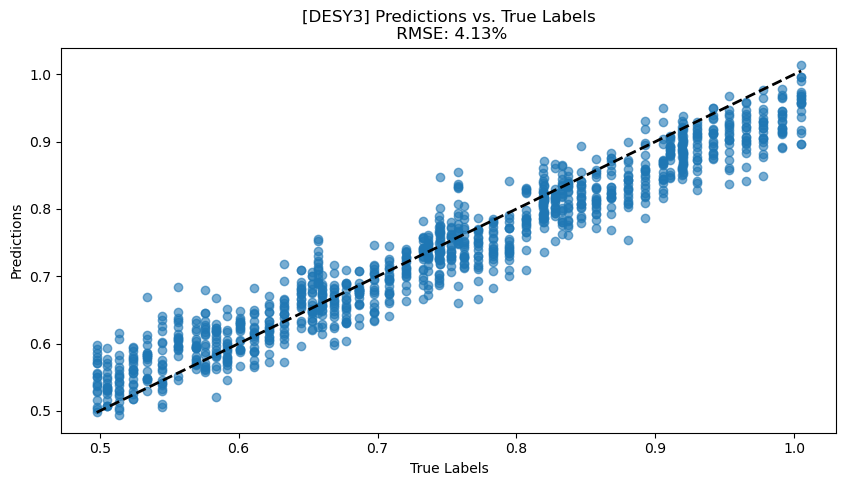

In [ ]:
container =np.load('CNN_container.npy',allow_pickle=True).item()




container = dict()
for pp in [0,1]:#range(2):
    container[pp] = dict()
    for LABEL in ['LSSTY10','LSSTY1','DESY3']: #'LSSTY10','LSSTY1',
        container[pp][LABEL] = dict()
        




for LABEL in ['LSSTY10','LSSTY1','DESY3']: #'LSSTY10','LSSTY1',

    if channels == 4:
        [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
        [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
    else:
        [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
        [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)

    params_LFI = np.array(params_LFI)
    params = np.array(params)
    params[:,1] = params[:,1] * np.sqrt(params[:,0]/0.3)
    params_LFI[:,1] = params_LFI[:,1] * np.sqrt(params_LFI[:,0]/0.3)

    
    
    idx = np.random.choice(range(len(params)), int(len(params)*0.7), replace=False)
    index_training = np.arange(len(params))[np.in1d( np.arange(len(params)),idx)]
    index_val =  np.arange(len(params))[~np.in1d( np.arange(len(params)),idx)]

    for pp in [0,1]: #om, S8
        if channels == 4:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
        else:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)

        params_LFI = np.array(params_LFI)
        params = np.array(params)
        params[:,1] = params[:,1] * np.sqrt(params[:,0]/0.3)
        params_LFI[:,1] = params_LFI[:,1] * np.sqrt(params_LFI[:,0]/0.3)



        if channels == 4:
            train_dataset_ = np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
        else:
            train_dataset_ = np.array(patches_to_save[3])[index_training]   # np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.array(patches_to_save[3])[index_val]          # np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.array(patches_to_save_LFI[3])[:]              #np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
           
            train_dataset_ = np.expand_dims(train_dataset_,axis=1)
            val_dataset_ = np.expand_dims(val_dataset_,axis=1)
            LFI_dataset_ = np.expand_dims(LFI_dataset_,axis=1)
        plt.show()





        class CustomDataset(Dataset):
            def __init__(self, data_tensor, params_tensor):
                """
                Args:
                    data_tensor (Tensor): A tensor containing the data, shape [N, C, size_patches, size_patches].
                    params_tensor (Tensor): A 1-D tensor containing the parameters, shape [N].
                """
                self.data_tensor = data_tensor
                self.params_tensor = params_tensor

            def __len__(self):
                # Return the number of items in the dataset
                return self.data_tensor.shape[0]

            def __getitem__(self, idx):
                # Return the data item and its corresponding parameter at the specified index
                data_item = self.data_tensor[idx]
                param_item = self.params_tensor[idx]
                return data_item, param_item

        # Assuming train_dataset_ and params[index_training,1] are already defined as described
        train_dataset = CustomDataset(train_dataset_, params[index_training, pp])
        val_dataset = CustomDataset(val_dataset_,     params[index_val, pp])
        LFI_dataset = CustomDataset(LFI_dataset_,     params_LFI[:, pp])

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        LFI_loader = DataLoader(LFI_dataset, batch_size=32, shuffle=False)

        # Load and modify the model
        model  = modify_resnet_for_regression()

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Example value for weight_decay

        # Device configuration
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Training loop
        # Initialize lists to store per-epoch training and validation loss
        epoch_training_losses = []
        epoch_validation_losses = []

        # Early stopping parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        patience = 15
        best_model_state = None  # To save the best model state

        # Training loop with early stopping and model reverting
        num_epochs = 100
        count_epochs = 0
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(device).float()
                labels = labels.to(device).float().view(-1, 1)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_training_losses.append(epoch_loss)  # Store training loss

            # Validation loop
            model.eval()
            val_loss = 0.0
            all_predictions = []
            all_labels = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device).float()
                    labels = labels.to(device).float().view(-1, 1)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * images.size(0)

                    # Store predictions and true labels for RMSE calculation and plotting
                    all_predictions.extend(outputs.view(-1).tolist())
                    all_labels.extend(labels.view(-1).tolist())

            val_loss = val_loss / len(val_loader.dataset)
            epoch_validation_losses.append(val_loss)  # Store validation loss

            count_epochs += 1
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

            # Check if validation loss improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs.')
                    model.load_state_dict(best_model_state)  # Revert to best model state
                    break  # Stop training

            # LFI checks loop ----------------
            
            
            
            
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, count_epochs+1), epoch_training_losses, label='Training Loss')
        plt.plot(range(1, count_epochs+1), epoch_validation_losses, label='Validation Loss')
        plt.title('Training vs. Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim([0,0.02])
        plt.legend()
        plt.show()

        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for images, labels in LFI_loader:
                images, labels = images.to(device).float(), labels.to(device).float().view(-1, 1)
                outputs = model(images)
                predictions.extend(outputs.view(-1).tolist())
                true_labels.extend(labels.view(-1).tolist())

        # Calculate RMSE
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)
        rmse = np.sqrt(np.mean((predictions - true_labels) ** 2))

        # Scatter plot with RMSE
        plt.figure(figsize=(10, 5))
        plt.scatter(true_labels, predictions, alpha=0.6)
        plt.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=2)  # Line for perfect predictions
        plt.title('[{0}] Predictions vs. True Labels\n RMSE: {1:.2f}%'.format(LABEL,100*rmse))
        plt.xlabel('True Labels')
        plt.ylabel('Predictions')
        plt.show()

        container[pp][LABEL] = {'DATA':predictions,'params':true_labels}
        np.save('CNN_container_resnet',container)

# CNN

In [ ]:
channels = 4
size_patches = 512

In [3]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model_normal_CNN(nn.Module):
    def __init__(self):
        super(Model_normal_CNN, self).__init__()
        # self.normalization = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(channels, 8, kernel_size=3) #
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.AdaptiveMaxPool2d((32,32))
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3)
        self.relu5 = nn.LeakyReLU()
        self.pool5 = nn.AdaptiveAvgPool2d((8,8))
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3)
        self.relu6 = nn.LeakyReLU()
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.relu6 = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 128) # Need to change this for different image size
        self.relu7 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu8 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu9 = nn.LeakyReLU()
        self.fc4 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.pool6(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.fc2(x)
        x = self.relu8(x)
        x = self.fc3(x)
        x = self.relu9(x)
        x = self.fc4(x)
        return x
    
    
    
    
    
    
class Model_normal_CNN_simpler(nn.Module):
    def __init__(self):
        super(Model_normal_CNN, self).__init__()
        # self.normalization = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(channels, 8, kernel_size=3) #
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.AdaptiveMaxPool2d((32,32))
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3)
        self.relu5 = nn.LeakyReLU()
        self.pool5 = nn.AdaptiveAvgPool2d((8,8))
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3)
        self.relu6 = nn.LeakyReLU()
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.relu6 = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 128) # Need to change this for different image size
        self.relu7 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu8 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu9 = nn.LeakyReLU()
        self.fc4 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.pool6(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.fc2(x)
        x = self.relu8(x)
        x = self.fc3(x)
        x = self.relu9(x)
        x = self.fc4(x)
        return x


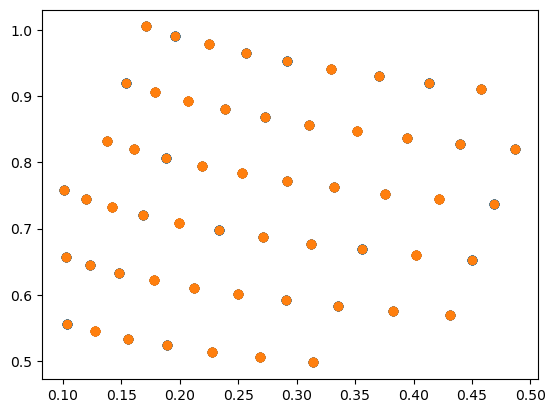

(399, 4, 512, 512)
Epoch 1/100, Loss: 0.0142, Validation Loss: 0.0105
Epoch 2/100, Loss: 0.0123, Validation Loss: 0.0109
Epoch 3/100, Loss: 0.0124, Validation Loss: 0.0104
Epoch 4/100, Loss: 0.0123, Validation Loss: 0.0106
Epoch 5/100, Loss: 0.0122, Validation Loss: 0.0104
Epoch 6/100, Loss: 0.0124, Validation Loss: 0.0104
Epoch 7/100, Loss: 0.0123, Validation Loss: 0.0105
Epoch 8/100, Loss: 0.0122, Validation Loss: 0.0104
Epoch 9/100, Loss: 0.0122, Validation Loss: 0.0105
Epoch 10/100, Loss: 0.0123, Validation Loss: 0.0104
Epoch 11/100, Loss: 0.0122, Validation Loss: 0.0105
Epoch 12/100, Loss: 0.0123, Validation Loss: 0.0104
Epoch 13/100, Loss: 0.0122, Validation Loss: 0.0105
Epoch 14/100, Loss: 0.0122, Validation Loss: 0.0104
Epoch 15/100, Loss: 0.0123, Validation Loss: 0.0104
Epoch 16/100, Loss: 0.0122, Validation Loss: 0.0105
Epoch 17/100, Loss: 0.0122, Validation Loss: 0.0105
Epoch 18/100, Loss: 0.0122, Validation Loss: 0.0105
Early stopping triggered after 18 epochs.


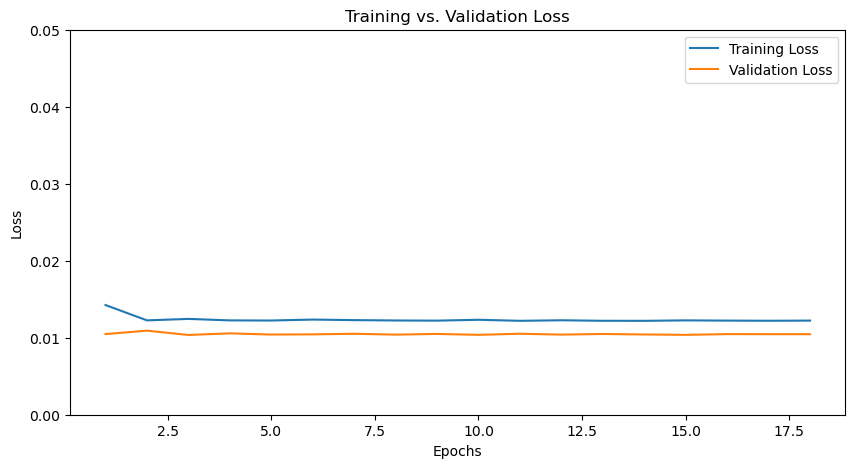

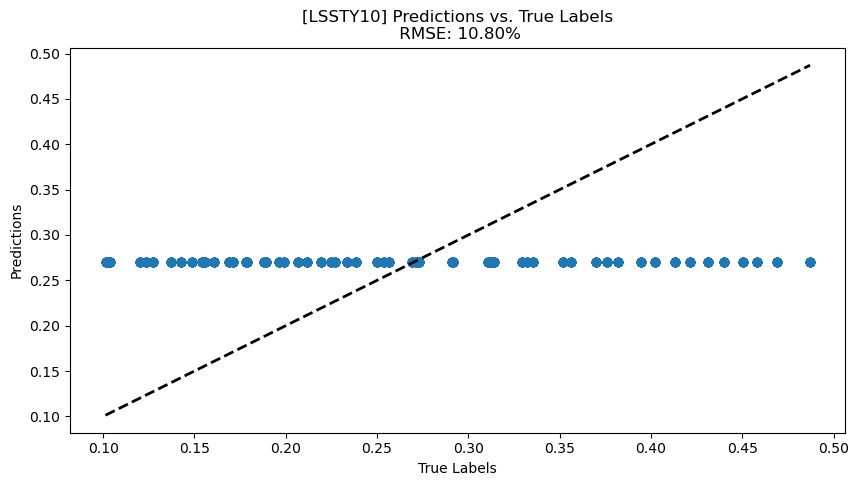

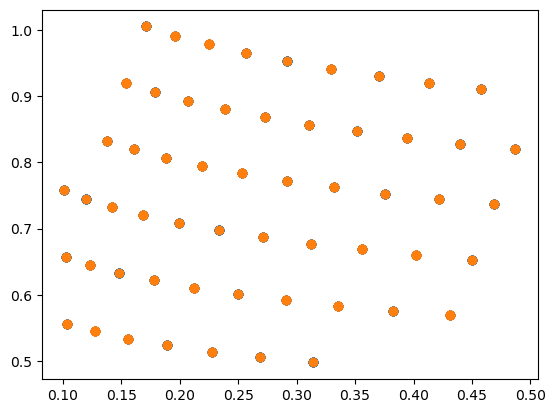

(399, 4, 512, 512)
Epoch 1/100, Loss: 0.0159, Validation Loss: 0.0112
Epoch 2/100, Loss: 0.0127, Validation Loss: 0.0112
Epoch 3/100, Loss: 0.0120, Validation Loss: 0.0110
Epoch 4/100, Loss: 0.0120, Validation Loss: 0.0110
Epoch 5/100, Loss: 0.0120, Validation Loss: 0.0110
Epoch 6/100, Loss: 0.0122, Validation Loss: 0.0111
Epoch 7/100, Loss: 0.0123, Validation Loss: 0.0109
Epoch 8/100, Loss: 0.0120, Validation Loss: 0.0110
Epoch 9/100, Loss: 0.0121, Validation Loss: 0.0110
Epoch 10/100, Loss: 0.0120, Validation Loss: 0.0109
Epoch 11/100, Loss: 0.0121, Validation Loss: 0.0110
Epoch 12/100, Loss: 0.0122, Validation Loss: 0.0109
Epoch 13/100, Loss: 0.0121, Validation Loss: 0.0110
Epoch 14/100, Loss: 0.0120, Validation Loss: 0.0109
Epoch 15/100, Loss: 0.0120, Validation Loss: 0.0110
Epoch 16/100, Loss: 0.0120, Validation Loss: 0.0110
Epoch 17/100, Loss: 0.0120, Validation Loss: 0.0109
Epoch 18/100, Loss: 0.0120, Validation Loss: 0.0110
Epoch 19/100, Loss: 0.0122, Validation Loss: 0.0109
Ep

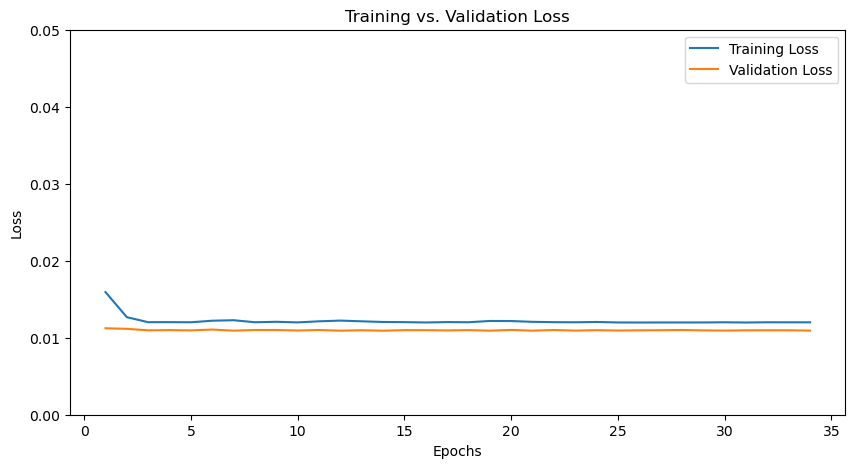

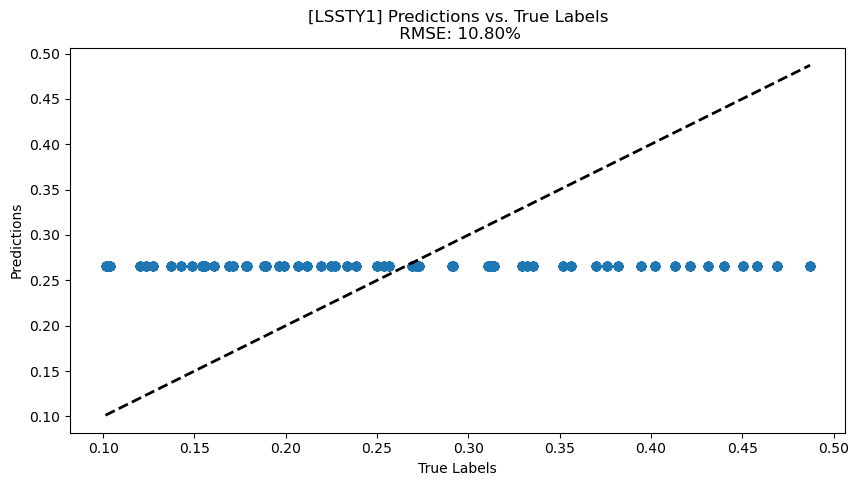

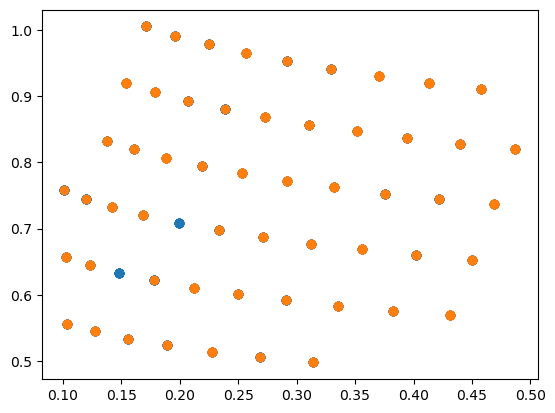

(399, 4, 512, 512)
Epoch 1/100, Loss: 0.0230, Validation Loss: 0.0157
Epoch 2/100, Loss: 0.0125, Validation Loss: 0.0130
Epoch 3/100, Loss: 0.0120, Validation Loss: 0.0119
Epoch 4/100, Loss: 0.0118, Validation Loss: 0.0129
Epoch 5/100, Loss: 0.0114, Validation Loss: 0.0123
Epoch 6/100, Loss: 0.0114, Validation Loss: 0.0126
Epoch 7/100, Loss: 0.0115, Validation Loss: 0.0122
Epoch 8/100, Loss: 0.0116, Validation Loss: 0.0123
Epoch 9/100, Loss: 0.0115, Validation Loss: 0.0125
Epoch 10/100, Loss: 0.0116, Validation Loss: 0.0131
Epoch 11/100, Loss: 0.0117, Validation Loss: 0.0132
Epoch 12/100, Loss: 0.0115, Validation Loss: 0.0122
Epoch 13/100, Loss: 0.0118, Validation Loss: 0.0134
Epoch 14/100, Loss: 0.0115, Validation Loss: 0.0123
Epoch 15/100, Loss: 0.0116, Validation Loss: 0.0126
Epoch 16/100, Loss: 0.0115, Validation Loss: 0.0120
Epoch 17/100, Loss: 0.0117, Validation Loss: 0.0128
Epoch 18/100, Loss: 0.0114, Validation Loss: 0.0120
Early stopping triggered after 18 epochs.


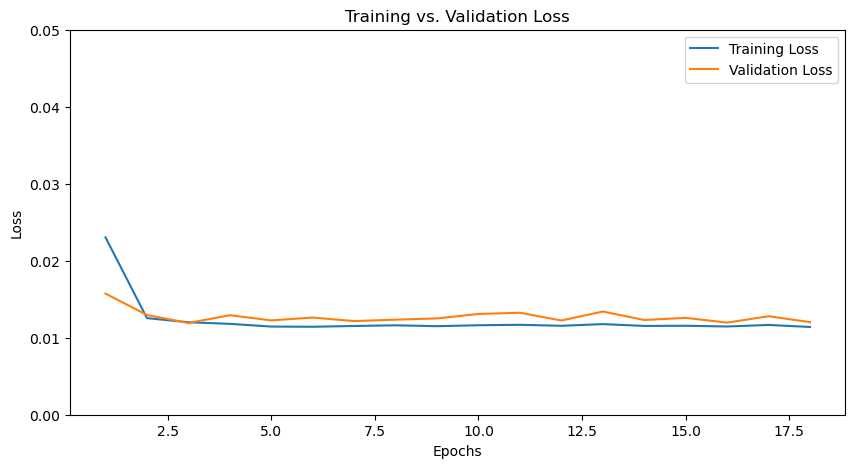

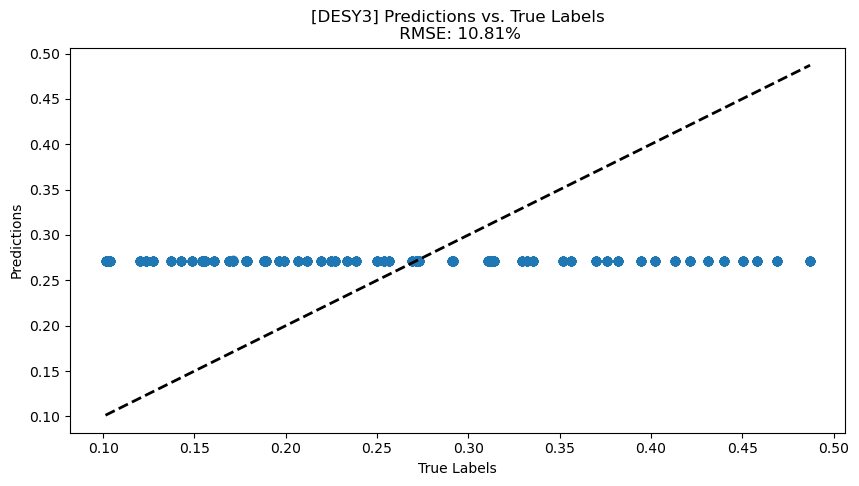

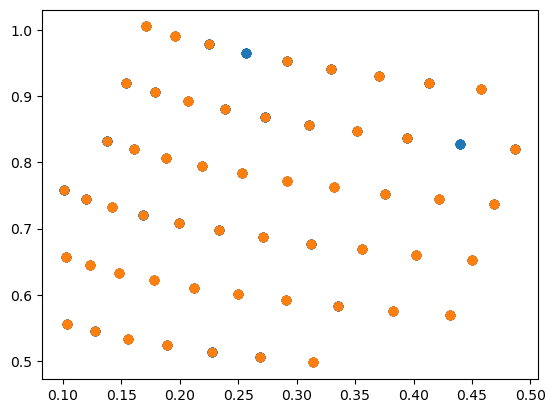

(399, 4, 512, 512)
Epoch 1/100, Loss: 0.2114, Validation Loss: 0.0193
Epoch 2/100, Loss: 0.0407, Validation Loss: 0.0195
Epoch 3/100, Loss: 0.0249, Validation Loss: 0.0194
Epoch 4/100, Loss: 0.0232, Validation Loss: 0.0215
Epoch 5/100, Loss: 0.0210, Validation Loss: 0.0236
Epoch 6/100, Loss: 0.0234, Validation Loss: 0.0187
Epoch 7/100, Loss: 0.0236, Validation Loss: 0.0196
Epoch 8/100, Loss: 0.0234, Validation Loss: 0.0216
Epoch 9/100, Loss: 0.0233, Validation Loss: 0.0185
Epoch 10/100, Loss: 0.0202, Validation Loss: 0.0184
Epoch 11/100, Loss: 0.0210, Validation Loss: 0.0190
Epoch 12/100, Loss: 0.0199, Validation Loss: 0.0214
Epoch 13/100, Loss: 0.0194, Validation Loss: 0.0178
Epoch 14/100, Loss: 0.0193, Validation Loss: 0.0233
Epoch 15/100, Loss: 0.0194, Validation Loss: 0.0172
Epoch 16/100, Loss: 0.0179, Validation Loss: 0.0243
Epoch 17/100, Loss: 0.0202, Validation Loss: 0.0179
Epoch 18/100, Loss: 0.0192, Validation Loss: 0.0176
Epoch 19/100, Loss: 0.0159, Validation Loss: 0.0172
Ep

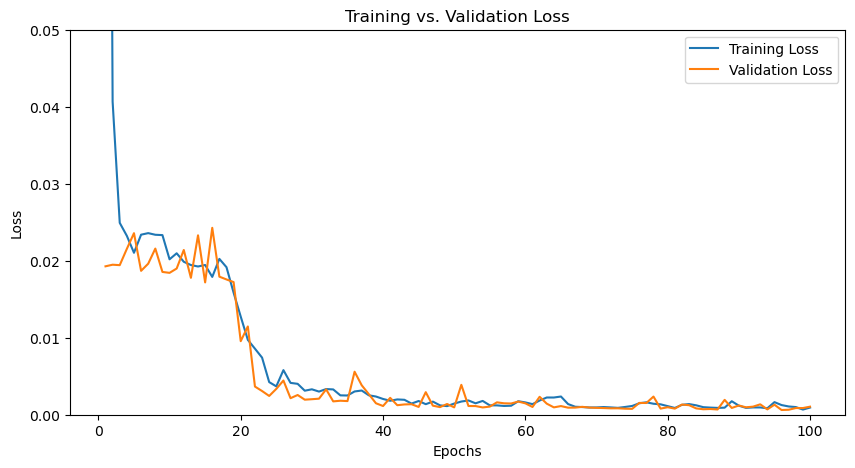

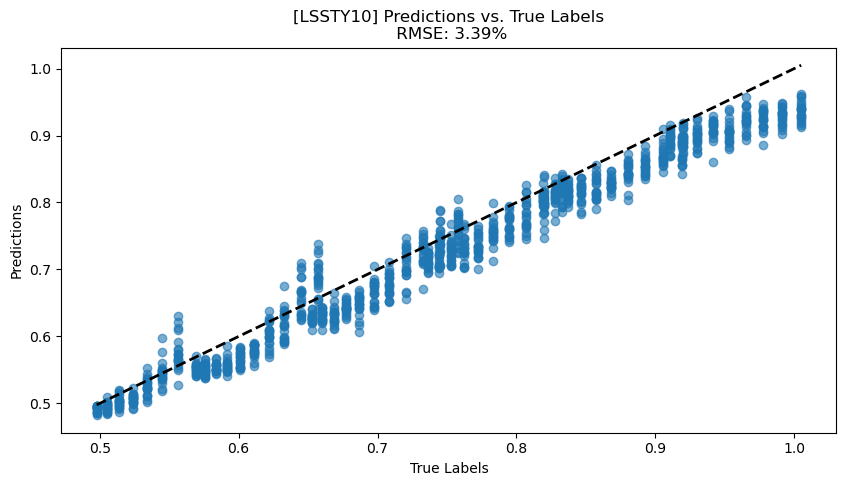

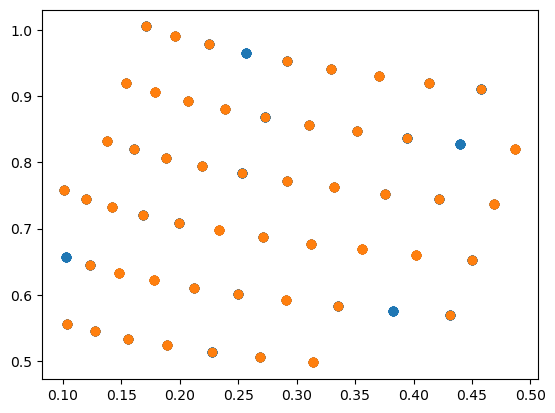

(399, 4, 512, 512)
Epoch 1/100, Loss: 0.4540, Validation Loss: 0.0236
Epoch 2/100, Loss: 0.0704, Validation Loss: 0.0272
Epoch 3/100, Loss: 0.0256, Validation Loss: 0.0288
Epoch 4/100, Loss: 0.0252, Validation Loss: 0.0228
Epoch 5/100, Loss: 0.0230, Validation Loss: 0.0203
Epoch 6/100, Loss: 0.0225, Validation Loss: 0.0191
Epoch 7/100, Loss: 0.0210, Validation Loss: 0.0189
Epoch 8/100, Loss: 0.0228, Validation Loss: 0.0243
Epoch 9/100, Loss: 0.0219, Validation Loss: 0.0208
Epoch 10/100, Loss: 0.0207, Validation Loss: 0.0228
Epoch 11/100, Loss: 0.0210, Validation Loss: 0.0208
Epoch 12/100, Loss: 0.0222, Validation Loss: 0.0190
Epoch 13/100, Loss: 0.0230, Validation Loss: 0.0221
Epoch 14/100, Loss: 0.0227, Validation Loss: 0.0192
Epoch 15/100, Loss: 0.0224, Validation Loss: 0.0190
Epoch 16/100, Loss: 0.0206, Validation Loss: 0.0186
Epoch 17/100, Loss: 0.0202, Validation Loss: 0.0189
Epoch 18/100, Loss: 0.0212, Validation Loss: 0.0205
Epoch 19/100, Loss: 0.0206, Validation Loss: 0.0187
Ep

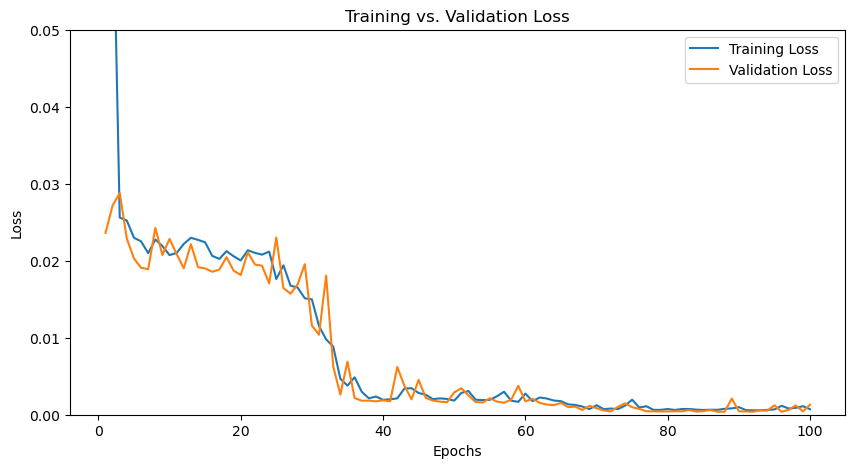

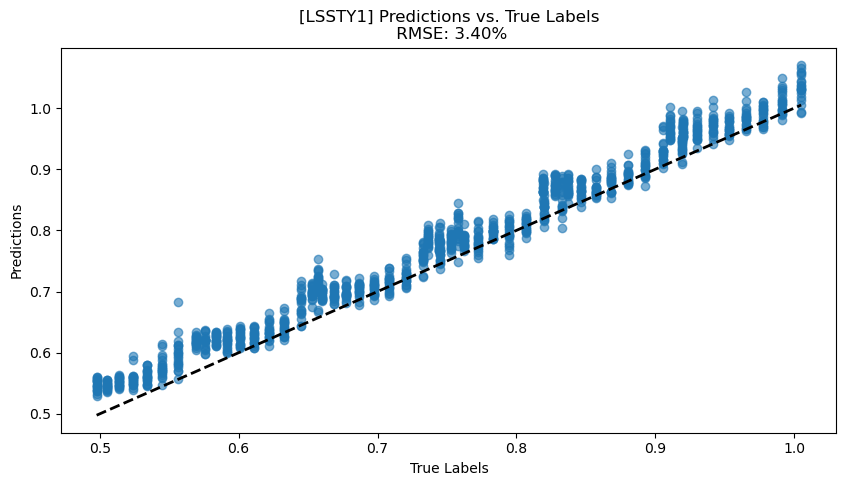

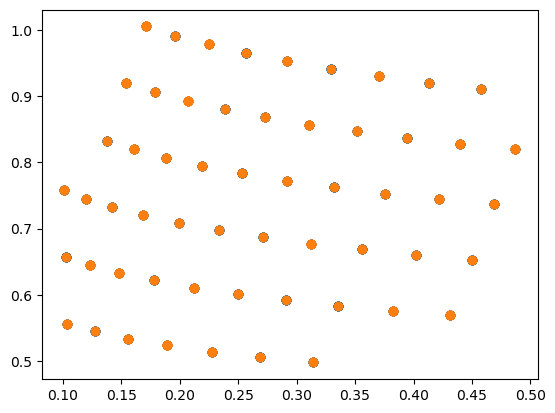

(399, 4, 512, 512)
Epoch 1/100, Loss: 0.2770, Validation Loss: 0.0235
Epoch 2/100, Loss: 0.0394, Validation Loss: 0.0271
Epoch 3/100, Loss: 0.0223, Validation Loss: 0.0235
Epoch 4/100, Loss: 0.0204, Validation Loss: 0.0212
Epoch 5/100, Loss: 0.0204, Validation Loss: 0.0212
Epoch 6/100, Loss: 0.0205, Validation Loss: 0.0218
Epoch 7/100, Loss: 0.0209, Validation Loss: 0.0233
Epoch 8/100, Loss: 0.0205, Validation Loss: 0.0293
Epoch 9/100, Loss: 0.0234, Validation Loss: 0.0220
Epoch 10/100, Loss: 0.0199, Validation Loss: 0.0228
Epoch 11/100, Loss: 0.0207, Validation Loss: 0.0224
Epoch 12/100, Loss: 0.0218, Validation Loss: 0.0225
Epoch 13/100, Loss: 0.0225, Validation Loss: 0.0203
Epoch 14/100, Loss: 0.0183, Validation Loss: 0.0202
Epoch 15/100, Loss: 0.0176, Validation Loss: 0.0164
Epoch 16/100, Loss: 0.0149, Validation Loss: 0.0148
Epoch 17/100, Loss: 0.0115, Validation Loss: 0.0140
Epoch 18/100, Loss: 0.0091, Validation Loss: 0.0102
Epoch 19/100, Loss: 0.0070, Validation Loss: 0.0050
Ep

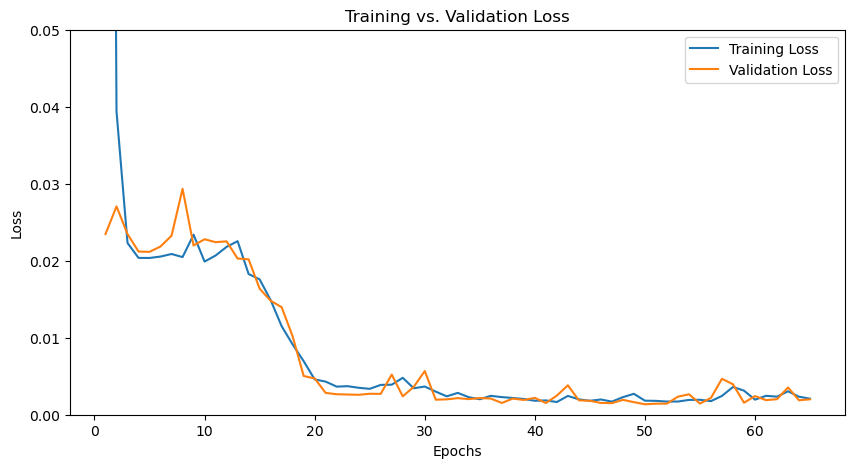

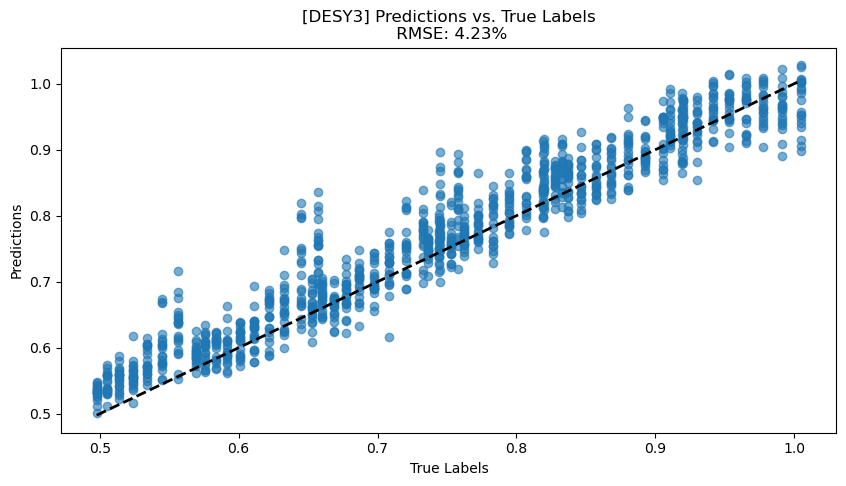

In [17]:
container =np.load('CNN_container.npy',allow_pickle=True).item()


for pp in [0,1]:#range(2):
    container[pp] = dict()
    for LABEL in ['LSSTY10','LSSTY1','DESY3']: #'LSSTY10','LSSTY1', infinite

        if channels == 4:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
            
        else:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
            
        params_LFI = np.array(params_LFI)

        params = np.array(params)
        params[:,1] = params[:,1] * np.sqrt(params[:,0]/0.3)
        params_LFI[:,1] = params_LFI[:,1] * np.sqrt(params_LFI[:,0]/0.3)

        idx = np.random.choice(range(len(params)), int(len(params)*0.7 ), replace=False)
        index_training = np.arange(len(params))[np.in1d( np.arange(len(params)),idx)]
        index_val =  np.arange(len(params))[~np.in1d( np.arange(len(params)),idx)]
        plt.scatter(params[index_training,0],params[index_training,1])
        plt.scatter(params[index_val,0],params[index_val,1])

        if channels == 4:
            train_dataset_ = np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
        else:
            train_dataset_ = np.array(patches_to_save[3])[index_training]   # np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.array(patches_to_save[3])[index_val]          # np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.array(patches_to_save_LFI[3])[:]              #np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
           
            train_dataset_ = np.expand_dims(train_dataset_,axis=1)
            val_dataset_ = np.expand_dims(val_dataset_,axis=1)
            LFI_dataset_ = np.expand_dims(LFI_dataset_,axis=1)
        plt.show()

        #'''

        print (train_dataset_.shape)
        # augment the data with a little bit of noise for better training ******************************************
        H = train_dataset_.shape[2]
        W = train_dataset_.shape[3]
        for n in range(val_dataset_.shape[0]):
            for y in range(val_dataset_.shape[1]):

                patch_std = np.std(val_dataset_[n, y, :, :])
                noise = np.random.normal(0, 0.1 * patch_std, (H, W))
                val_dataset_[n, y, :, :] += noise

        for n in range(train_dataset_.shape[0]):
            for y in range(train_dataset_.shape[1]):

                patch_std = np.std(train_dataset_[n, y, :, :])
                noise = np.random.normal(0, 0.1 * patch_std, (H, W))
                train_dataset_[n, y, :, :] += noise

        # *********************************************************************************************************

        #'''

        class CustomDataset(Dataset):
            def __init__(self, data_tensor, params_tensor):
                """
                Args:
                    data_tensor (Tensor): A tensor containing the data, shape [2254, 4, 224, 224].
                    params_tensor (Tensor): A 1-D tensor containing the parameters, shape [2254].
                """
                self.data_tensor = data_tensor
                self.params_tensor = params_tensor

            def __len__(self):
                # Return the number of items in the dataset
                return self.data_tensor.shape[0]

            def __getitem__(self, idx):
                # Return the data item and its corresponding parameter at the specified index
                data_item = self.data_tensor[idx]
                param_item = self.params_tensor[idx]
                return data_item, param_item

        # Assuming train_dataset_ and params[index_training,1] are already defined as described
        train_dataset = CustomDataset(train_dataset_, params[index_training, pp])
        val_dataset = CustomDataset(val_dataset_,     params[index_val, pp])
        LFI_dataset = CustomDataset(LFI_dataset_,     params_LFI[:, pp])

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        LFI_loader = DataLoader(LFI_dataset, batch_size=32, shuffle=False)

        # Load and modify the model
        model  = Model_normal_CNN()#modify_resnet_for_regression(num_channels=4)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Example value for weight_decay

        # Device configuration
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Training loop
        # Initialize lists to store per-epoch training and validation loss
        epoch_training_losses = []
        epoch_validation_losses = []

        # Early stopping parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        patience = 15
        best_model_state = None  # To save the best model state

        # Training loop with early stopping and model reverting
        num_epochs = 100
        count_epochs = 0
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(device).float()
                labels = labels.to(device).float().view(-1, 1)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_training_losses.append(epoch_loss)  # Store training loss

            # Validation loop
            model.eval()
            val_loss = 0.0
            all_predictions = []
            all_labels = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device).float()
                    labels = labels.to(device).float().view(-1, 1)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * images.size(0)

                    # Store predictions and true labels for RMSE calculation and plotting
                    all_predictions.extend(outputs.view(-1).tolist())
                    #print (np.mean(np.var(outputs.view(-1).tolist())))
                    all_labels.extend(labels.view(-1).tolist())

            val_loss = val_loss / len(val_loader.dataset)
            epoch_validation_losses.append(val_loss)  # Store validation loss

            count_epochs += 1
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

            # Check if validation loss improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs.')
                    model.load_state_dict(best_model_state)  # Revert to best model state
                    break  # Stop training


        plt.figure(figsize=(10, 5))
        plt.plot(range(1, count_epochs+1), epoch_training_losses, label='Training Loss')
        plt.plot(range(1, count_epochs+1), epoch_validation_losses, label='Validation Loss')
        plt.title('Training vs. Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim([0,0.05])
        plt.legend()
        plt.show()

        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for images, labels in LFI_loader:
                images, labels = images.to(device).float(), labels.to(device).float().view(-1, 1)
                outputs = model(images)
                predictions.extend(outputs.view(-1).tolist())
                true_labels.extend(labels.view(-1).tolist())

        # Calculate RMSE
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)
        rmse = np.sqrt(np.mean((predictions - true_labels) ** 2))

        # Scatter plot with RMSE
        plt.figure(figsize=(10, 5))
        plt.scatter(true_labels, predictions, alpha=0.6)
        plt.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=2)  # Line for perfect predictions
        plt.title('[{0}] Predictions vs. True Labels\n RMSE: {1:.2f}%'.format(LABEL,100*rmse))
        plt.xlabel('True Labels')
        plt.ylabel('Predictions')
        plt.show()

        container[pp][LABEL] = {'DATA':predictions,'params':true_labels}
        np.save('CNN_container',container)

In [17]:
for pp in container.keys():
    for LABEL in container[pp].keys():
        rmse = np.sqrt(np.mean((container[pp][LABEL]['DATA']-container[pp][LABEL]['params'])**2))*100
        print (pp,LABEL,'{0:2.2f}'.format(rmse))


1 infinite 4.03
1 LSSTY10 4.89
1 LSSTY1 6.16
1 DESY3 7.27
0 infinite 7.23
0 LSSTY10 10.80
0 LSSTY1 10.83
0 DESY3 10.91


# CNN shuffle

In [ ]:
channels = 4
size_patches = 512

In [ ]:
class Model_shuffle_CNN(nn.Module):
    def __init__(self):
        super(Model_shuffle_CNN, self).__init__()
        # self.normalization = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3) #
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.relu4 = nn.LeakyReLU()
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 128) # Need to change this for different image size
        self.relu7 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu8 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu9 = nn.LeakyReLU()
        self.fc4 = nn.Linear(32, 1)
        self.this_shift_idx = torch.stack([torch.range(0,62**2).type(torch.int64) for _ in range(64)])
    def randomize_images(self, tensor, image_size):
        # Flatten the images into rows
        # print("testing1", tensor.shape)
        x_flat = tensor.view(-1, image_size*image_size)  # Shape: [2*128, 36]
        # print("testing2", x_flat.shape, image_size)
        # Generate random permutations for each row
        # Note: If you want a different permutation for each row, create an index array for that
        idx = torch.stack([torch.randperm(image_size*image_size) for _ in range(x_flat.size(0))])
        # print("testing3", idx.shape)
        if tensor.is_cuda:
            idx = idx.cuda()
        # Apply permutations
        x_randomized_flat = torch.gather(x_flat, 1, idx)
        # Reshape back to the original shape
        return x_randomized_flat.view(tensor.shape[0], tensor.shape[1], image_size, image_size)
    def shift_images(self, tensor, image_size, shift_idx):
        batch_size = tensor.shape[0]
        idx = torch.cat([shift_idx for _ in range(batch_size)])
        x_flat = tensor.view(-1, image_size*image_size)  # Shape: [2*128, 36]
        if tensor.is_cuda:
            idx = idx.cuda()
        # Apply permutations
        x_randomized_flat = torch.gather(x_flat, 1, idx)
        # Reshape back to the original shape
        return x_randomized_flat.view(tensor.shape[0], tensor.shape[1], image_size, image_size)
    def update_epoch(self, epoch):
         self.current_epoch = epoch
    def forward(self, x):
        # x = self.normalization(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        if self.current_epoch >=10:
            # update the shuffling index every 10 epoch
            if self.current_epoch % 10==0:
                self.this_shift_idx = torch.stack([torch.randperm(62**2) for _ in range(64)])
            # print("shuffling update")
            x = self.shift_images(x, x.shape[-1], self.this_shift_idx)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool6(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.fc2(x)
        x = self.relu8(x)
        x = self.fc3(x)
        x = self.relu9(x)
        x = self.fc4(x)
        return x



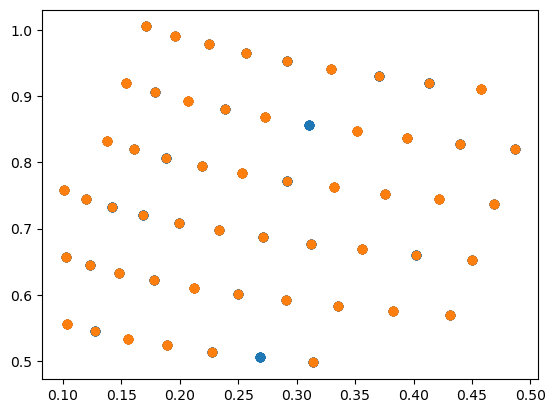

(399, 4, 512, 512)


/tmp/ipykernel_754766/3174565958.py:25: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.this_shift_idx = torch.stack([torch.range(0,62**2).type(torch.int64) for _ in range(64)])


Epoch 1/300, Loss: 0.5772, Validation Loss: 0.0470
Epoch 2/300, Loss: 0.0620, Validation Loss: 0.0579
Epoch 3/300, Loss: 0.0305, Validation Loss: 0.0275
Epoch 4/300, Loss: 0.0252, Validation Loss: 0.0199
Epoch 5/300, Loss: 0.0208, Validation Loss: 0.0209
Epoch 6/300, Loss: 0.0208, Validation Loss: 0.0194
Epoch 7/300, Loss: 0.0205, Validation Loss: 0.0193
Epoch 8/300, Loss: 0.0199, Validation Loss: 0.0194
Epoch 9/300, Loss: 0.0198, Validation Loss: 0.0190
Epoch 10/300, Loss: 0.0195, Validation Loss: 0.0189
Epoch 11/300, Loss: 0.0192, Validation Loss: 0.0202
Epoch 12/300, Loss: 0.0191, Validation Loss: 0.0193
Epoch 13/300, Loss: 0.0179, Validation Loss: 0.0171
Epoch 14/300, Loss: 0.0175, Validation Loss: 0.0174
Epoch 15/300, Loss: 0.0172, Validation Loss: 0.0168
Epoch 16/300, Loss: 0.0158, Validation Loss: 0.0136
Epoch 17/300, Loss: 0.0135, Validation Loss: 0.0140
Epoch 18/300, Loss: 0.0130, Validation Loss: 0.0108
Epoch 19/300, Loss: 0.0126, Validation Loss: 0.0114
Epoch 20/300, Loss: 0

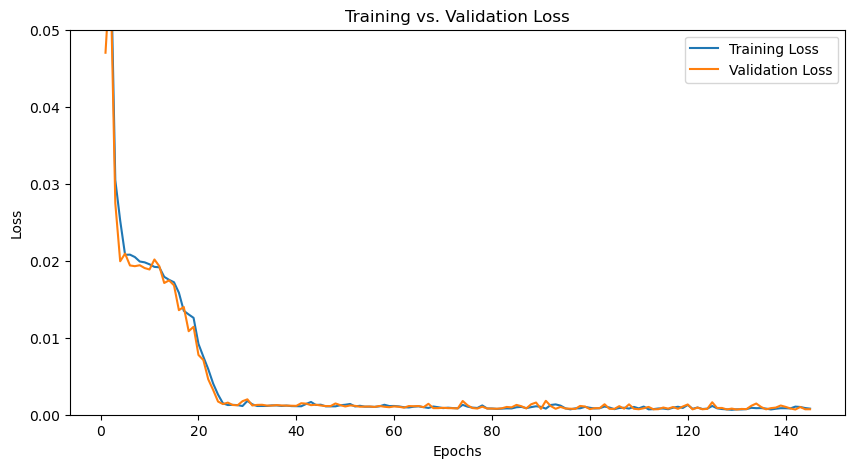

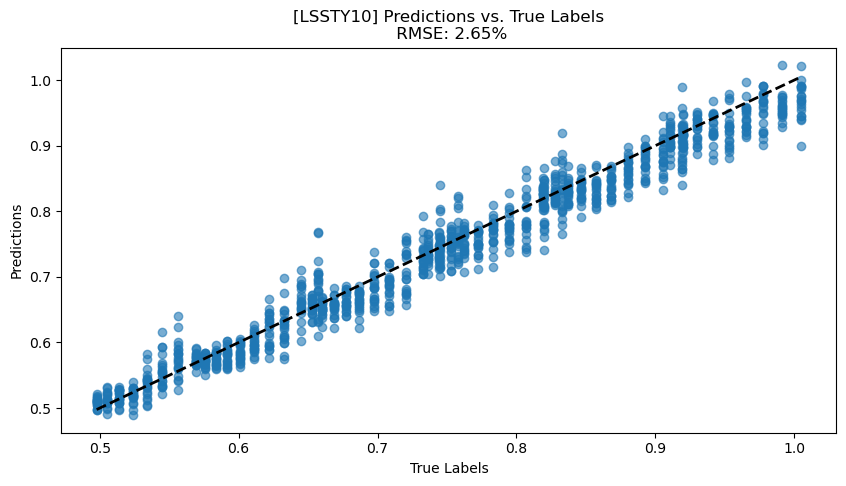

(399, 4, 512, 512)
Epoch 1/300, Loss: 0.0353, Validation Loss: 0.0224
Epoch 2/300, Loss: 0.0143, Validation Loss: 0.0137
Epoch 3/300, Loss: 0.0121, Validation Loss: 0.0126
Epoch 4/300, Loss: 0.0119, Validation Loss: 0.0125
Epoch 5/300, Loss: 0.0118, Validation Loss: 0.0122
Epoch 6/300, Loss: 0.0116, Validation Loss: 0.0121
Epoch 7/300, Loss: 0.0116, Validation Loss: 0.0121
Epoch 8/300, Loss: 0.0116, Validation Loss: 0.0121
Epoch 9/300, Loss: 0.0116, Validation Loss: 0.0121
Epoch 10/300, Loss: 0.0117, Validation Loss: 0.0122
Epoch 11/300, Loss: 0.0121, Validation Loss: 0.0121
Epoch 12/300, Loss: 0.0120, Validation Loss: 0.0123
Epoch 13/300, Loss: 0.0121, Validation Loss: 0.0121
Epoch 14/300, Loss: 0.0116, Validation Loss: 0.0121
Epoch 15/300, Loss: 0.0115, Validation Loss: 0.0121
Epoch 16/300, Loss: 0.0115, Validation Loss: 0.0121
Epoch 17/300, Loss: 0.0115, Validation Loss: 0.0121
Epoch 18/300, Loss: 0.0115, Validation Loss: 0.0121
Epoch 19/300, Loss: 0.0115, Validation Loss: 0.0121
Ep

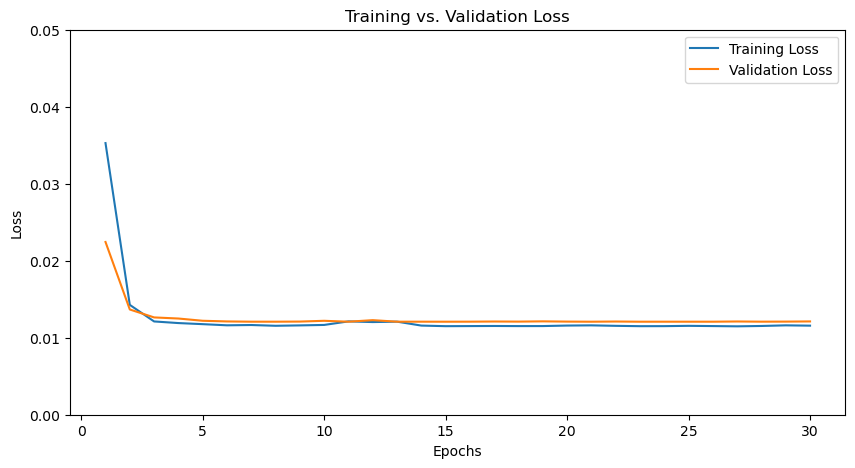

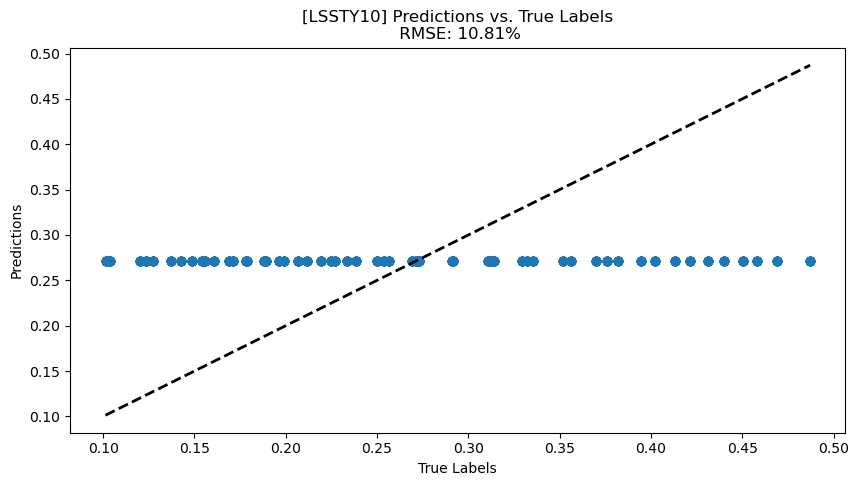

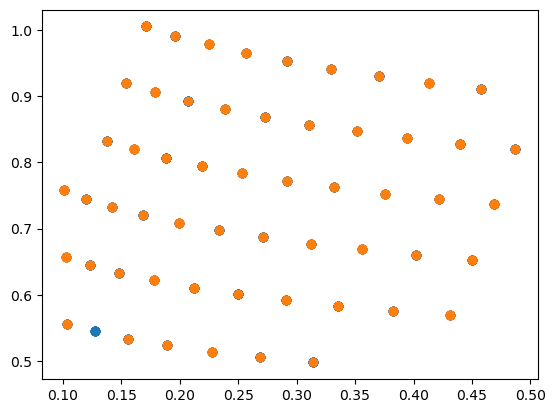

(399, 4, 512, 512)
Epoch 1/300, Loss: 0.3372, Validation Loss: 0.0387
Epoch 2/300, Loss: 0.0608, Validation Loss: 0.0555
Epoch 3/300, Loss: 0.0263, Validation Loss: 0.0189
Epoch 4/300, Loss: 0.0220, Validation Loss: 0.0201
Epoch 5/300, Loss: 0.0221, Validation Loss: 0.0195
Epoch 6/300, Loss: 0.0205, Validation Loss: 0.0204
Epoch 7/300, Loss: 0.0207, Validation Loss: 0.0199
Epoch 8/300, Loss: 0.0208, Validation Loss: 0.0189
Epoch 9/300, Loss: 0.0207, Validation Loss: 0.0196
Epoch 10/300, Loss: 0.0211, Validation Loss: 0.0188
Epoch 11/300, Loss: 0.0203, Validation Loss: 0.0191
Epoch 12/300, Loss: 0.0206, Validation Loss: 0.0188
Epoch 13/300, Loss: 0.0202, Validation Loss: 0.0194
Epoch 14/300, Loss: 0.0205, Validation Loss: 0.0191
Epoch 15/300, Loss: 0.0202, Validation Loss: 0.0188
Epoch 16/300, Loss: 0.0202, Validation Loss: 0.0185
Epoch 17/300, Loss: 0.0202, Validation Loss: 0.0184
Epoch 18/300, Loss: 0.0204, Validation Loss: 0.0186
Epoch 19/300, Loss: 0.0200, Validation Loss: 0.0193
Ep

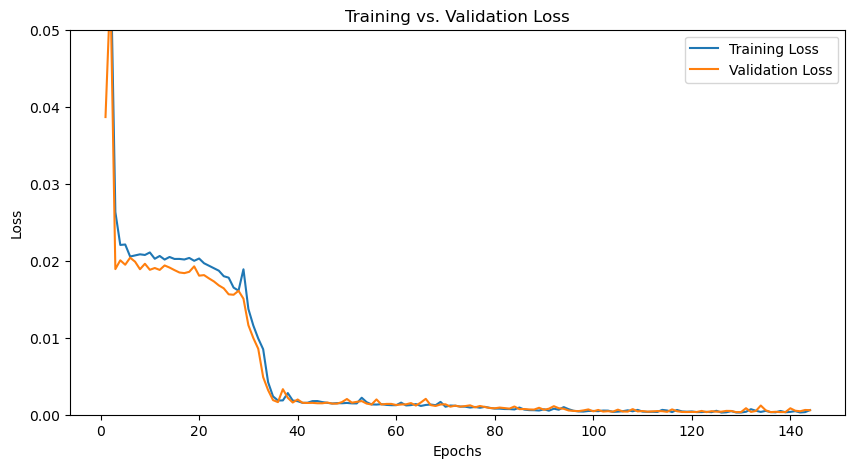

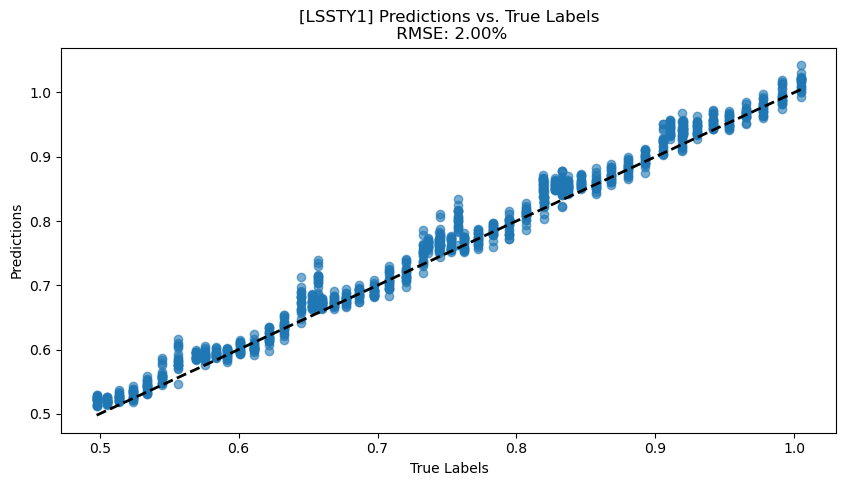

(399, 4, 512, 512)
Epoch 1/300, Loss: 0.0199, Validation Loss: 0.0119
Epoch 2/300, Loss: 0.0120, Validation Loss: 0.0117
Epoch 3/300, Loss: 0.0118, Validation Loss: 0.0117
Epoch 4/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 5/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 6/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 7/300, Loss: 0.0117, Validation Loss: 0.0118
Epoch 8/300, Loss: 0.0118, Validation Loss: 0.0117
Epoch 9/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 10/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 11/300, Loss: 0.0121, Validation Loss: 0.0117
Epoch 12/300, Loss: 0.0118, Validation Loss: 0.0117
Epoch 13/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 14/300, Loss: 0.0119, Validation Loss: 0.0117
Epoch 15/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 16/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 17/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 18/300, Loss: 0.0117, Validation Loss: 0.0117
Epoch 19/300, Loss: 0.0117, Validation Loss: 0.0117
Ep

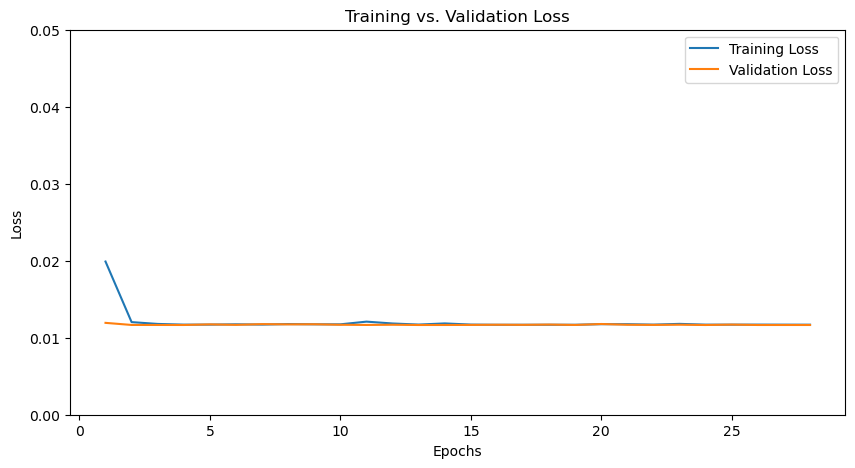

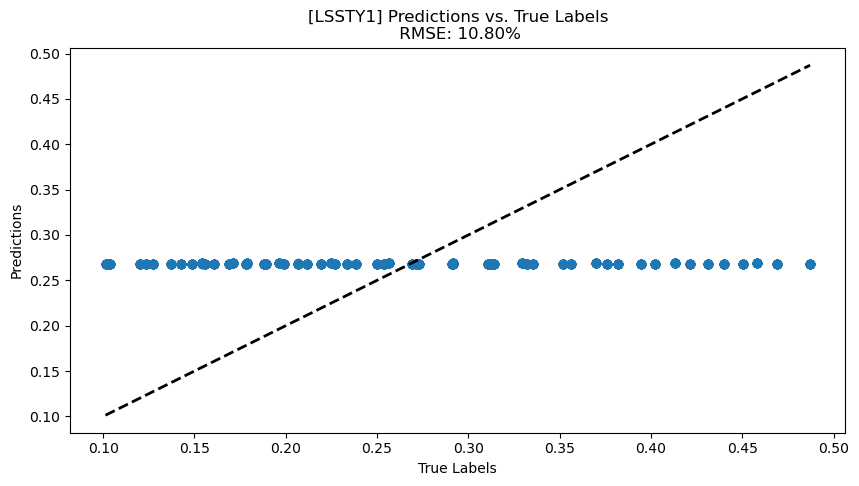

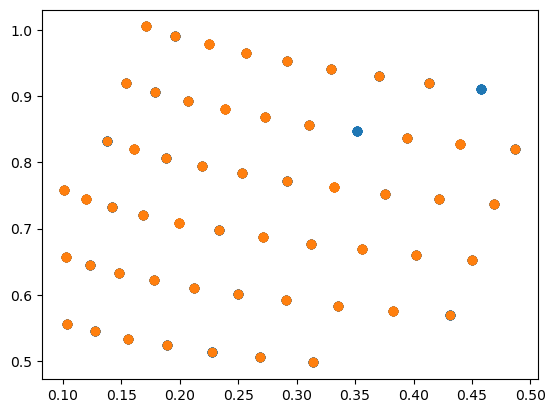

(399, 4, 512, 512)
Epoch 1/300, Loss: 0.5089, Validation Loss: 0.1952
Epoch 2/300, Loss: 0.0928, Validation Loss: 0.0275
Epoch 3/300, Loss: 0.0329, Validation Loss: 0.0383
Epoch 4/300, Loss: 0.0246, Validation Loss: 0.0187
Epoch 5/300, Loss: 0.0212, Validation Loss: 0.0184
Epoch 6/300, Loss: 0.0214, Validation Loss: 0.0191
Epoch 7/300, Loss: 0.0210, Validation Loss: 0.0184
Epoch 8/300, Loss: 0.0210, Validation Loss: 0.0207
Epoch 9/300, Loss: 0.0213, Validation Loss: 0.0193
Epoch 10/300, Loss: 0.0211, Validation Loss: 0.0183
Epoch 11/300, Loss: 0.0221, Validation Loss: 0.0190
Epoch 12/300, Loss: 0.0219, Validation Loss: 0.0206
Epoch 13/300, Loss: 0.0216, Validation Loss: 0.0183
Epoch 14/300, Loss: 0.0210, Validation Loss: 0.0185
Epoch 15/300, Loss: 0.0216, Validation Loss: 0.0208
Epoch 16/300, Loss: 0.0229, Validation Loss: 0.0182
Epoch 17/300, Loss: 0.0221, Validation Loss: 0.0205
Epoch 18/300, Loss: 0.0210, Validation Loss: 0.0183
Epoch 19/300, Loss: 0.0219, Validation Loss: 0.0181
Ep

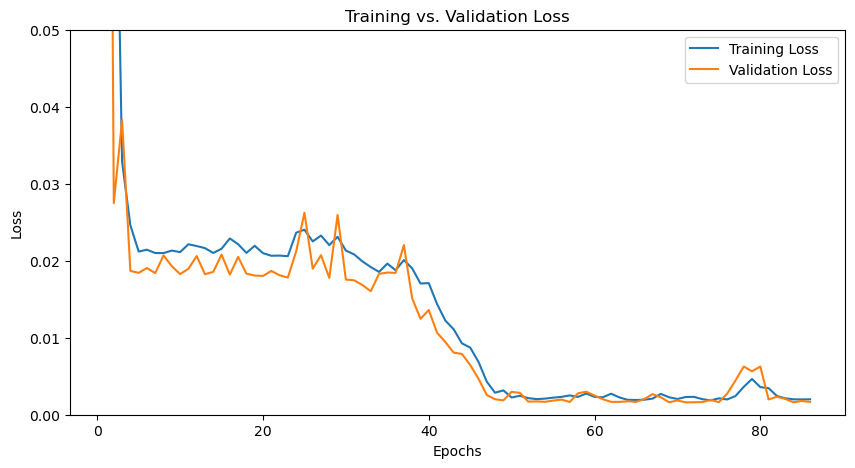

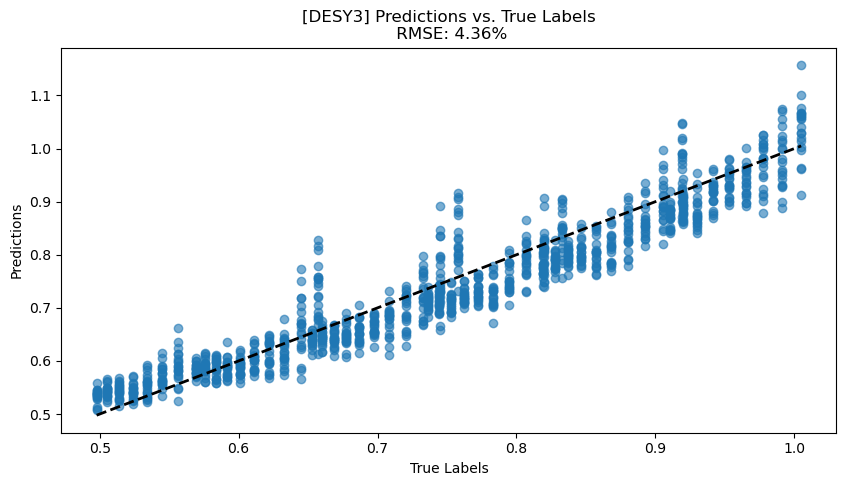

(399, 4, 512, 512)
Epoch 1/300, Loss: 0.0546, Validation Loss: 0.0169
Epoch 2/300, Loss: 0.0143, Validation Loss: 0.0125
Epoch 3/300, Loss: 0.0123, Validation Loss: 0.0116
Epoch 4/300, Loss: 0.0127, Validation Loss: 0.0109
Epoch 5/300, Loss: 0.0123, Validation Loss: 0.0109
Epoch 6/300, Loss: 0.0121, Validation Loss: 0.0135
Epoch 7/300, Loss: 0.0128, Validation Loss: 0.0108
Epoch 8/300, Loss: 0.0123, Validation Loss: 0.0110
Epoch 9/300, Loss: 0.0127, Validation Loss: 0.0116
Epoch 10/300, Loss: 0.0123, Validation Loss: 0.0111
Epoch 11/300, Loss: 0.0122, Validation Loss: 0.0111
Epoch 12/300, Loss: 0.0121, Validation Loss: 0.0108
Epoch 13/300, Loss: 0.0121, Validation Loss: 0.0111
Epoch 14/300, Loss: 0.0123, Validation Loss: 0.0120
Epoch 15/300, Loss: 0.0123, Validation Loss: 0.0109
Epoch 16/300, Loss: 0.0127, Validation Loss: 0.0109
Epoch 17/300, Loss: 0.0122, Validation Loss: 0.0137
Epoch 18/300, Loss: 0.0125, Validation Loss: 0.0109
Epoch 19/300, Loss: 0.0124, Validation Loss: 0.0109
Ep

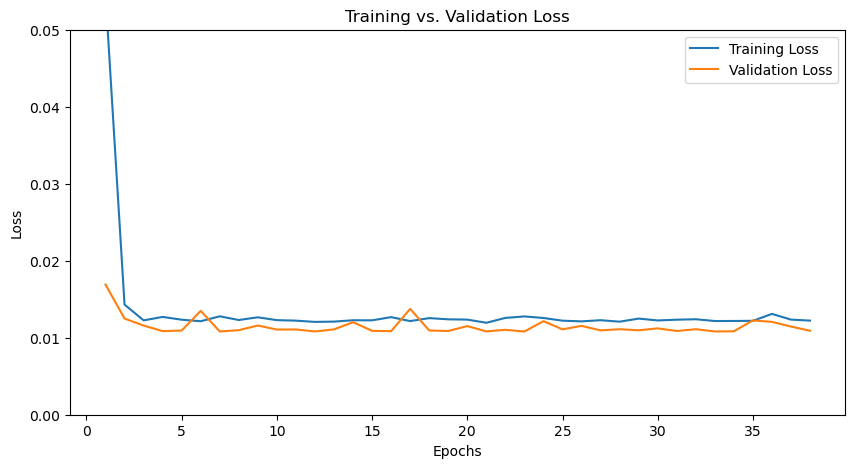

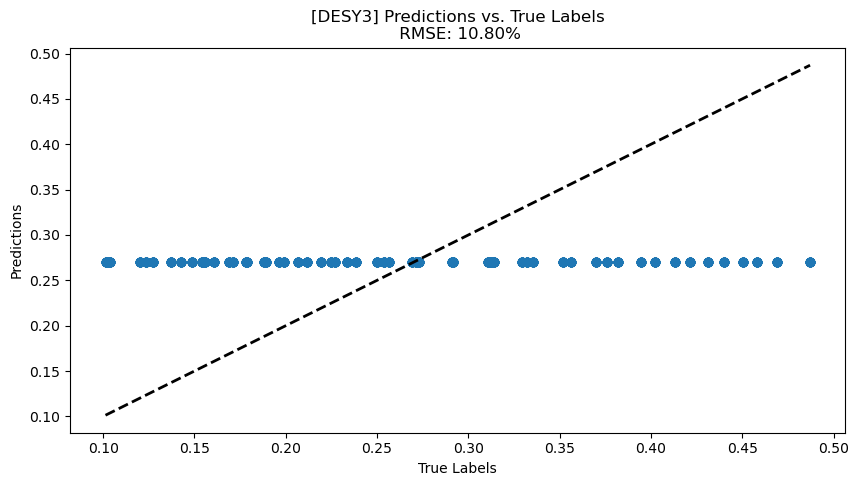

In [ ]:
container = dict()



container = dict()
for pp in [0,1]:#range(2):
    container[pp] = dict()
    for LABEL in ['LSSTY10','LSSTY1','DESY3']: #'LSSTY10','LSSTY1',
        container[pp][LABEL] = dict()
        


        
        


for LABEL in ['LSSTY10','LSSTY1','DESY3']: #'LSSTY10','LSSTY1', infinite

    if channels == 4:
        [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
        [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)

    else:
        [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
        [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)

    params_LFI = np.array(params_LFI)
    params = np.array(params)
    params[:,1] = params[:,1] * np.sqrt(params[:,0]/0.3)
    params_LFI[:,1] = params_LFI[:,1] * np.sqrt(params_LFI[:,0]/0.3)

    idx = np.random.choice(range(len(params)), int(len(params)*0.7 ), replace=False)
    index_training = np.arange(len(params))[np.in1d( np.arange(len(params)),idx)]
    index_val =  np.arange(len(params))[~np.in1d( np.arange(len(params)),idx)]
    plt.scatter(params[index_training,0],params[index_training,1])
    plt.scatter(params[index_val,0],params[index_val,1])
    
    for pp in [1,0]:#range(2):
        
        if channels == 4:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)

        else:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)

        params_LFI = np.array(params_LFI)
        params = np.array(params)
        params[:,1] = params[:,1] * np.sqrt(params[:,0]/0.3)
        params_LFI[:,1] = params_LFI[:,1] * np.sqrt(params_LFI[:,0]/0.3)


    
        if channels == 4:
            train_dataset_ = np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
        else:
            train_dataset_ = np.array(patches_to_save[3])[index_training]   # np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.array(patches_to_save[3])[index_val]          # np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.array(patches_to_save_LFI[3])[:]              #np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
           
            train_dataset_ = np.expand_dims(train_dataset_,axis=1)
            val_dataset_ = np.expand_dims(val_dataset_,axis=1)
            LFI_dataset_ = np.expand_dims(LFI_dataset_,axis=1)
        plt.show()

        #'''

        print (train_dataset_.shape)
        # augment the data with a little bit of noise for better training ******************************************
        H = train_dataset_.shape[2]
        W = train_dataset_.shape[3]
        for n in range(val_dataset_.shape[0]):
            for y in range(val_dataset_.shape[1]):

                patch_std = np.std(val_dataset_[n, y, :, :])
                noise = np.random.normal(0, 0.1 * patch_std, (H, W))
                val_dataset_[n, y, :, :] += noise

        for n in range(train_dataset_.shape[0]):
            for y in range(train_dataset_.shape[1]):

                patch_std = np.std(train_dataset_[n, y, :, :])
                noise = np.random.normal(0, 0.1 * patch_std, (H, W))
                train_dataset_[n, y, :, :] += noise

        # *********************************************************************************************************

        #'''

        class CustomDataset(Dataset):
            def __init__(self, data_tensor, params_tensor):
                """
                Args:
                    data_tensor (Tensor): A tensor containing the data, shape [2254, 4, 224, 224].
                    params_tensor (Tensor): A 1-D tensor containing the parameters, shape [2254].
                """
                self.data_tensor = data_tensor
                self.params_tensor = params_tensor

            def __len__(self):
                # Return the number of items in the dataset
                return self.data_tensor.shape[0]

            def __getitem__(self, idx):
                # Return the data item and its corresponding parameter at the specified index
                data_item = self.data_tensor[idx]
                param_item = self.params_tensor[idx]
                return data_item, param_item

        # Assuming train_dataset_ and params[index_training,1] are already defined as described
        train_dataset = CustomDataset(train_dataset_, params[index_training, pp])
        val_dataset = CustomDataset(val_dataset_,     params[index_val, pp])
        LFI_dataset = CustomDataset(LFI_dataset_,     params_LFI[:, pp])

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        LFI_loader = DataLoader(LFI_dataset, batch_size=32, shuffle=False)

        # Load and modify the model
        model  = Model_shuffle_CNN()#modify_resnet_for_regression(num_channels=4)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Example value for weight_decay

        # Device configuration
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Training loop
        # Initialize lists to store per-epoch training and validation loss
        epoch_training_losses = []
        epoch_validation_losses = []

        # Early stopping parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        patience = 15
        best_model_state = None  # To save the best model state

        # Training loop with early stopping and model reverting
        num_epochs = 300
        count_epochs = 0
        for epoch in range(num_epochs):
            model.update_epoch(epoch)
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(device).float()
                labels = labels.to(device).float().view(-1, 1)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_training_losses.append(epoch_loss)  # Store training loss

            # Validation loop
            model.eval()
            val_loss = 0.0
            all_predictions = []
            all_labels = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device).float()
                    labels = labels.to(device).float().view(-1, 1)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * images.size(0)

                    # Store predictions and true labels for RMSE calculation and plotting
                    all_predictions.extend(outputs.view(-1).tolist())
                    #print (np.mean(np.var(outputs.view(-1).tolist())))
                    all_labels.extend(labels.view(-1).tolist())

            val_loss = val_loss / len(val_loader.dataset)
            epoch_validation_losses.append(val_loss)  # Store validation loss

            count_epochs += 1
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

            # Check if validation loss improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs.')
                    model.load_state_dict(best_model_state)  # Revert to best model state
                    break  # Stop training


        plt.figure(figsize=(10, 5))
        plt.plot(range(1, count_epochs+1), epoch_training_losses, label='Training Loss')
        plt.plot(range(1, count_epochs+1), epoch_validation_losses, label='Validation Loss')
        plt.title('Training vs. Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim([0,0.05])
        plt.legend()
        plt.show()

        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for images, labels in LFI_loader:
                images, labels = images.to(device).float(), labels.to(device).float().view(-1, 1)
                outputs = model(images)
                predictions.extend(outputs.view(-1).tolist())
                true_labels.extend(labels.view(-1).tolist())

        # Calculate RMSE
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)
        rmse = np.sqrt(np.mean((predictions - true_labels) ** 2))

        # Scatter plot with RMSE
        plt.figure(figsize=(10, 5))
        plt.scatter(true_labels, predictions, alpha=0.6)
        plt.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=2)  # Line for perfect predictions
        plt.title('[{0}] Predictions vs. True Labels\n RMSE: {1:.2f}%'.format(LABEL,100*rmse))
        plt.xlabel('True Labels')
        plt.ylabel('Predictions')
        plt.show()

        container[pp][LABEL] = {'DATA':predictions,'params':true_labels}
        np.save('CNN_container_shuffle',container)

# ViT (not pre-trained)

In [4]:
!pip install transformers
import sys
import copy
sys.path.append('/global/u2/m/mgatti/.local/perlmutter/pytorch2.0.1/lib/python3.9/site-packages/')
import transformers

Defaulting to user installation because normal site-packages is not writeable


In [5]:
channels = 4
size_patches = 512 # 512

Epoch 1, Training Loss: 0.34984516409727245
Epoch 1, Validation Loss: 0.07172893546521664
Epoch 2, Training Loss: 0.04445438079822522
Epoch 2, Validation Loss: 0.02115084199855725
Epoch 3, Training Loss: 0.02839705691887782
Epoch 3, Validation Loss: 0.022478663983444374
Epoch 4, Training Loss: 0.02672227271474325
Epoch 4, Validation Loss: 0.02423255890607834
Epoch 5, Training Loss: 0.02590457392999759
Epoch 5, Validation Loss: 0.017483891143153112
Epoch 6, Training Loss: 0.02446903961782272
Epoch 6, Validation Loss: 0.016125894462068874
Epoch 7, Training Loss: 0.019135658271037616
Epoch 7, Validation Loss: 0.010731909268846115
Epoch 8, Training Loss: 0.012188519530284863
Epoch 8, Validation Loss: 0.005587179912254214
Epoch 9, Training Loss: 0.008377913779650744
Epoch 9, Validation Loss: 0.007982225234930715
Epoch 10, Training Loss: 0.006779006646516232
Epoch 10, Validation Loss: 0.008929731945196787
Epoch 11, Training Loss: 0.005112680069242532
Epoch 11, Validation Loss: 0.013117810556

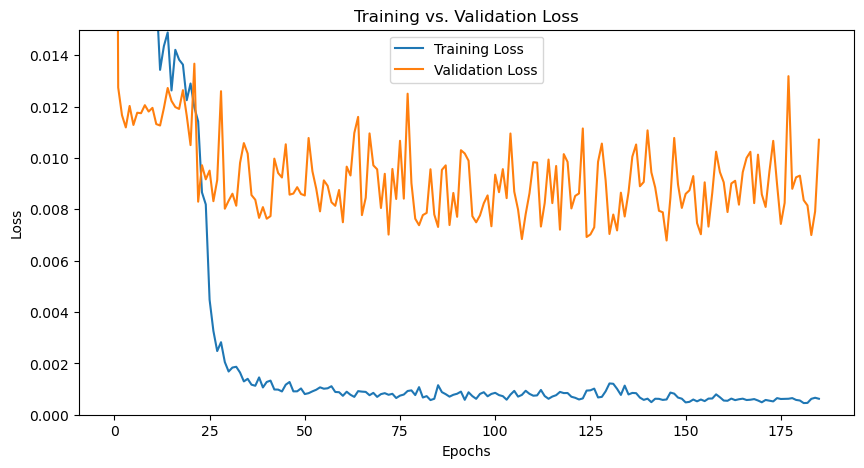

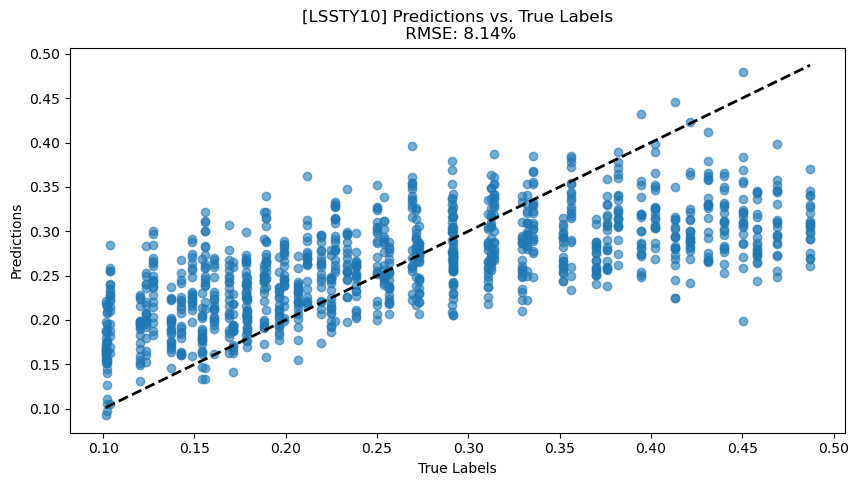

Epoch 1, Training Loss: 0.1394000778404566
Epoch 1, Validation Loss: 0.04591858231772979
Epoch 2, Training Loss: 0.0439896067747703
Epoch 2, Validation Loss: 0.021131652873009443
Epoch 3, Training Loss: 0.028970761654468682
Epoch 3, Validation Loss: 0.01923002939050396
Epoch 4, Training Loss: 0.029050270668589152
Epoch 4, Validation Loss: 0.018823264477153618
Epoch 5, Training Loss: 0.02739738243130537
Epoch 5, Validation Loss: 0.01890417483324806
Epoch 6, Training Loss: 0.026160520143233813
Epoch 6, Validation Loss: 0.017491630588968594
Epoch 7, Training Loss: 0.025780516461684153
Epoch 7, Validation Loss: 0.018883788492530584
Epoch 8, Training Loss: 0.025559132775435082
Epoch 8, Validation Loss: 0.01828350406140089
Epoch 9, Training Loss: 0.02300388666872795
Epoch 9, Validation Loss: 0.028334815986454487
Epoch 10, Training Loss: 0.02810568348146402
Epoch 10, Validation Loss: 0.021822516806423664
Epoch 11, Training Loss: 0.02283158368216111
Epoch 11, Validation Loss: 0.014968711572388

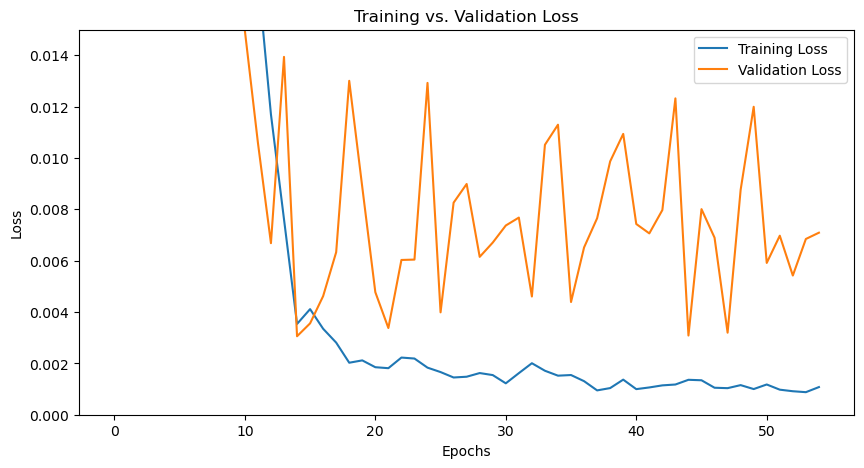

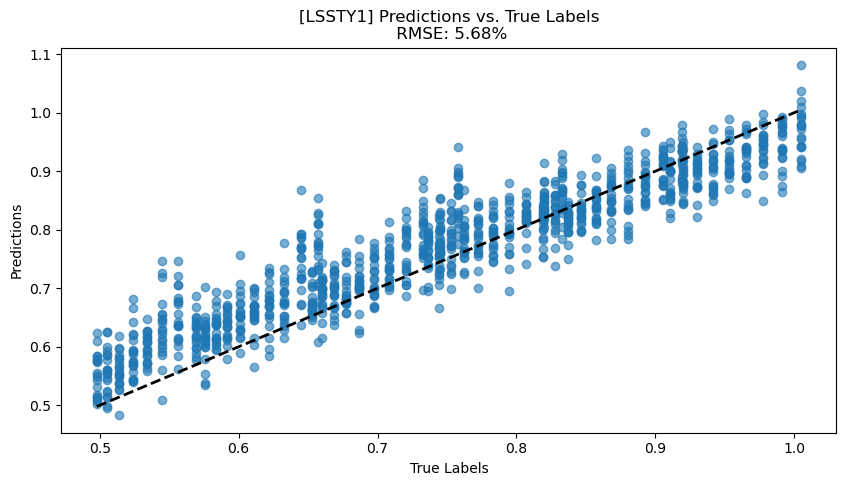

Epoch 1, Training Loss: 0.17683616567116517
Epoch 1, Validation Loss: 0.03892171041419109
Epoch 2, Training Loss: 0.025006327419899978
Epoch 2, Validation Loss: 0.010856289726992449
Epoch 3, Training Loss: 0.018133003407945998
Epoch 3, Validation Loss: 0.012403467359642187
Epoch 4, Training Loss: 0.015199354563194972
Epoch 4, Validation Loss: 0.012306316445271174
Epoch 5, Training Loss: 0.014170224133592386
Epoch 5, Validation Loss: 0.011068933022518953
Epoch 6, Training Loss: 0.014479594233517464
Epoch 6, Validation Loss: 0.010484483713905016
Epoch 7, Training Loss: 0.015275425420930753
Epoch 7, Validation Loss: 0.010638039869566759
Epoch 8, Training Loss: 0.015308585662681323
Epoch 8, Validation Loss: 0.011484411234656969
Epoch 9, Training Loss: 0.014958552729624968
Epoch 9, Validation Loss: 0.010680243683358034
Epoch 10, Training Loss: 0.01390833192719863
Epoch 10, Validation Loss: 0.011268931596229473
Epoch 11, Training Loss: 0.012923370043818768
Epoch 11, Validation Loss: 0.010864

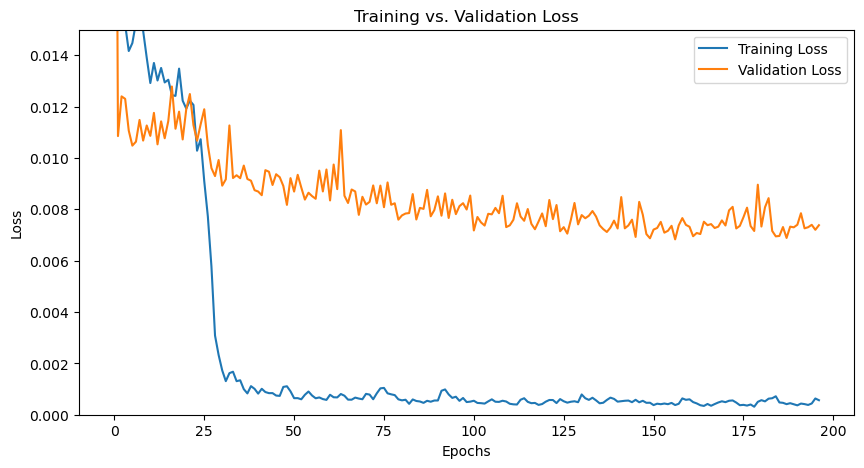

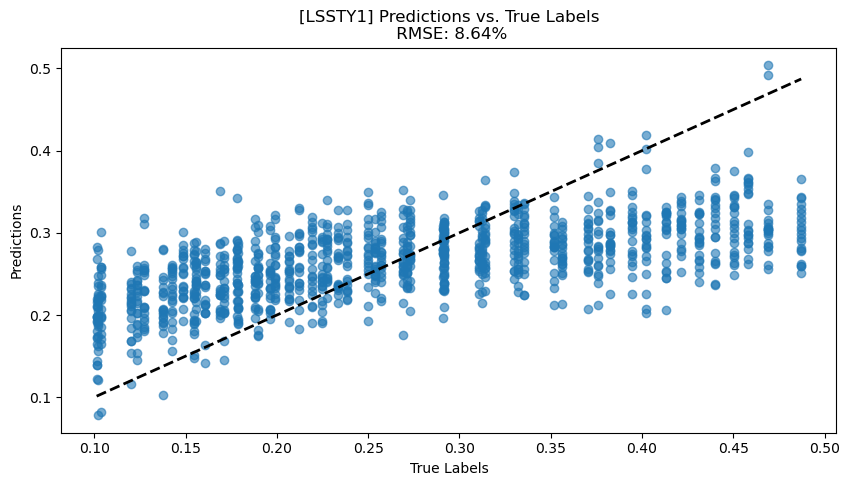

Epoch 1, Training Loss: 0.12044711439655377
Epoch 1, Validation Loss: 0.026873839708666008
Epoch 2, Training Loss: 0.03330919132209741
Epoch 2, Validation Loss: 0.024091136020918686
Epoch 3, Training Loss: 0.027560641415990315
Epoch 3, Validation Loss: 0.021280430257320404
Epoch 4, Training Loss: 0.023874997089688595
Epoch 4, Validation Loss: 0.021592703958352406
Epoch 5, Training Loss: 0.02348887289945896
Epoch 5, Validation Loss: 0.0208932946746548
Epoch 6, Training Loss: 0.024677147085850056
Epoch 6, Validation Loss: 0.019742869461576145
Epoch 7, Training Loss: 0.02202850551559375
Epoch 7, Validation Loss: 0.02199085894972086
Epoch 8, Training Loss: 0.02338673260349494
Epoch 8, Validation Loss: 0.01907395338639617
Epoch 9, Training Loss: 0.0219052775691335
Epoch 9, Validation Loss: 0.018510657362639904
Epoch 10, Training Loss: 0.021116667068921603
Epoch 10, Validation Loss: 0.02004178985953331
Epoch 11, Training Loss: 0.01797948541262975
Epoch 11, Validation Loss: 0.0107163640980919

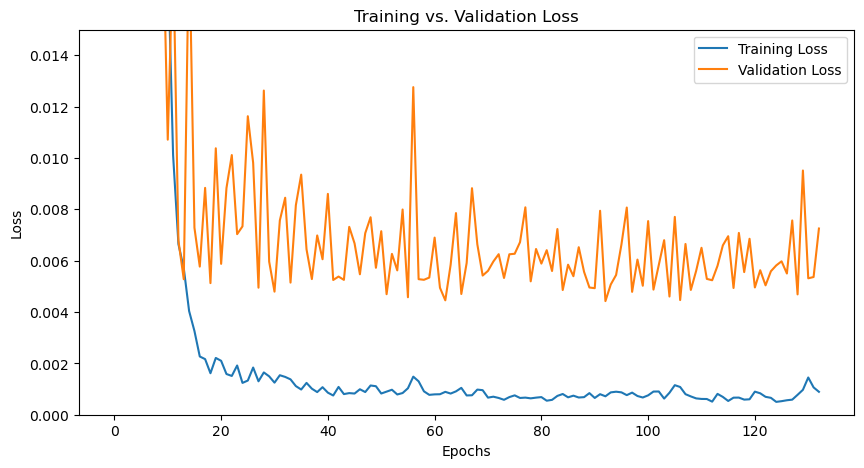

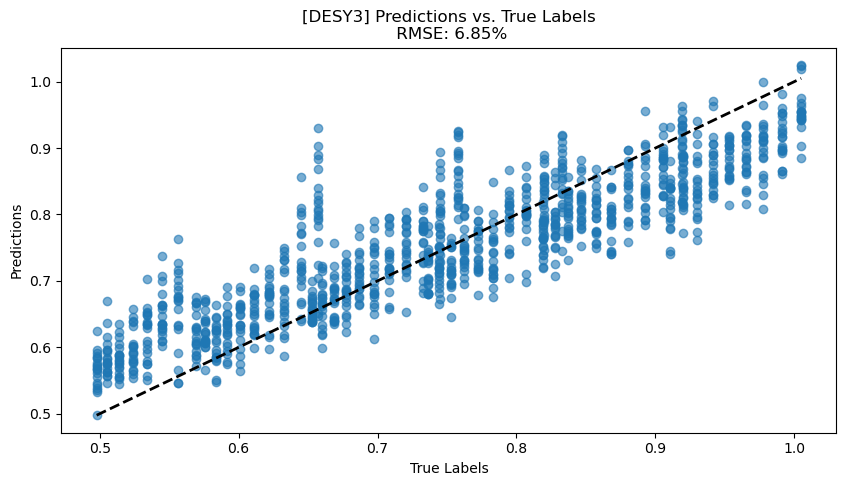

Epoch 1, Training Loss: 0.10309911290040383
Epoch 1, Validation Loss: 0.03617672699814042
Epoch 2, Training Loss: 0.02543201927955334
Epoch 2, Validation Loss: 0.012669716806461414
Epoch 3, Training Loss: 0.018116367407716237
Epoch 3, Validation Loss: 0.0113429706543684
Epoch 4, Training Loss: 0.01540626141314323
Epoch 4, Validation Loss: 0.011485624592751265
Epoch 5, Training Loss: 0.015744630390634902
Epoch 5, Validation Loss: 0.011316842632368207
Epoch 6, Training Loss: 0.015670624633248035
Epoch 6, Validation Loss: 0.01196294417604804
Epoch 7, Training Loss: 0.013724670243950991
Epoch 7, Validation Loss: 0.01134175481274724
Epoch 8, Training Loss: 0.015806557682271186
Epoch 8, Validation Loss: 0.011193797768404087
Epoch 9, Training Loss: 0.013371593605440397
Epoch 9, Validation Loss: 0.011651949336131414
Epoch 10, Training Loss: 0.01476116987088552
Epoch 10, Validation Loss: 0.011250537975380817
Epoch 11, Training Loss: 0.013653717576884307
Epoch 11, Validation Loss: 0.012350623340

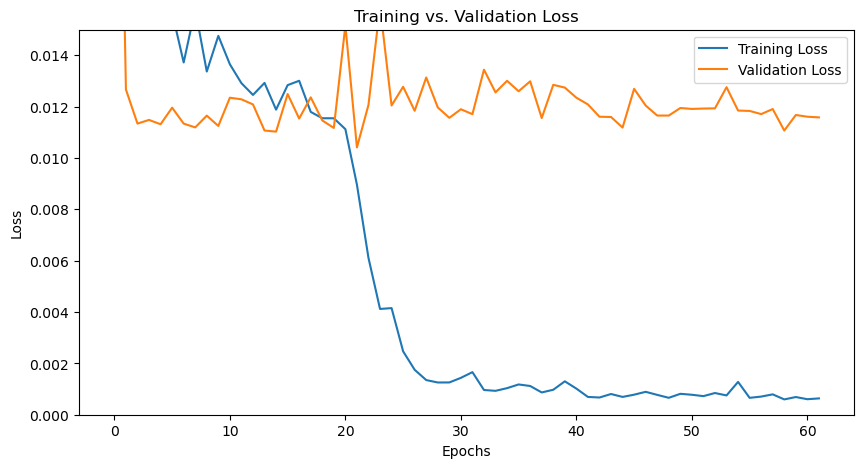

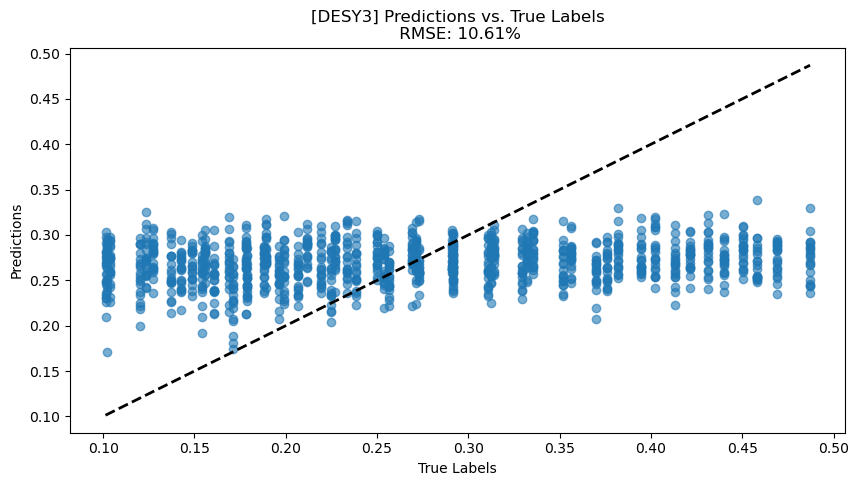

In [6]:
from transformers import ViTForImageClassification, ViTConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, data_tensor, params_tensor):
        """
        Args:
            data_tensor (Tensor): A tensor containing the data, shape [2254, 4, 224, 224].
            params_tensor (Tensor): A 1-D tensor containing the parameters, shape [2254].
        """
        self.data_tensor = data_tensor
        self.params_tensor = params_tensor

    def __len__(self):
        # Return the number of items in the dataset
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        # Return the data item and its corresponding parameter at the specified index
        data_item = self.data_tensor[idx]
        param_item = self.params_tensor[idx]
        return data_item, param_item
            
class ViTForRegression(ViTForImageClassification):
    def __init__(self, config, num_input_channels=4):  # Ensure 4 channels are specified
        super().__init__(config)
        
        # Adjust the patch embeddings for the specified number of input channels
        self.vit.embeddings.patch_embeddings.projection = nn.Conv2d(
            in_channels=num_input_channels,  # This should now be 4
            out_channels=config.hidden_size,
            kernel_size=(config.patch_size, config.patch_size),
            stride=(config.patch_size, config.patch_size),
        )

        # Modify the classifier for regression
        self.classifier = nn.Linear(config.hidden_size, 1)

        # Adjust the patch embeddings to accept num_input_channels
        # This assumes you have access to the configuration of the embedding layer such as patch size
        self.vit.embeddings.patch_embeddings.projection = nn.Conv2d(
            in_channels=num_input_channels,
            out_channels=config.hidden_size,
            kernel_size=(config.patch_size, config.patch_size),
            stride=(config.patch_size, config.patch_size),
        )

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values=pixel_values)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output[:, 0, :])

        loss = None
        if labels is not None:
            # Calculate MSE loss
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits.squeeze(), labels.squeeze())
        return loss, logits


    


# define index for training/validation here so we always use the same ---
LABEL = 'LSSTY10'
if channels == 4:

    [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
    [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)

    #[patches_to_save_LFI,params_LFI] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
    #[patches_to_save,params]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)

else:

    [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
    [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)






container_vit = dict()
for pp in [0,1]:#range(2):
    container_vit[pp] = dict()
    for LABEL in ['LSSTY10','LSSTY1','DESY3']: #'LSSTY10','LSSTY1',
        container_vit[pp][LABEL] = dict()
        


for LABEL in ['LSSTY10','LSSTY1','DESY3']: #'LSSTY10','LSSTY1',

    
    if channels == 4:
        [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
        [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
    else:
        [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
        [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
        
    params_LFI = np.array(params_LFI)
    params = np.array(params)
    params[:,1] = params[:,1] * np.sqrt(params[:,0]/0.3)
    params_LFI[:,1] = params_LFI[:,1] * np.sqrt(params_LFI[:,0]/0.3)

    
    idx = np.random.choice(range(len(params)), int(len(params)*0.7), replace=False)
    index_training = np.arange(len(params))[np.in1d( np.arange(len(params)),idx)]
    index_val =  np.arange(len(params))[~np.in1d( np.arange(len(params)),idx)]

    for pp in [1,0]:#range(2):
        if channels == 4:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/training/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{1}/LFI/{0}.npy'.format(LABEL,size_patches),allow_pickle=True)
        else:
            [patches_to_save,params] = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/training/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
            [patches_to_save_LFI,params_LFI]  = np.load('/global/cfs/cdirs/des/mgatti/VIT_data_{2}/LFI/{0}_{1}.npy'.format(LABEL,channels,size_patches),allow_pickle=True)
        
        params_LFI = np.array(params_LFI)
        params = np.array(params)
        params[:,1] = params[:,1] * np.sqrt(params[:,0]/0.3)
        params_LFI[:,1] = params_LFI[:,1] * np.sqrt(params_LFI[:,0]/0.3)


        if channels == 4:
            train_dataset_ = np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
        else:
            train_dataset_ = np.array(patches_to_save[3])[index_training]   # np.stack((np.array(patches_to_save[1])[index_training],np.array(patches_to_save[2])[index_training],np.array(patches_to_save[3])[index_training],np.array(patches_to_save[4])[index_training]), axis=1)
            val_dataset_ = np.array(patches_to_save[3])[index_val]          # np.stack((np.array(patches_to_save[1])[index_val],np.array(patches_to_save[2])[index_val],np.array(patches_to_save[3])[index_val],np.array(patches_to_save[4])[index_val]), axis=1)
            LFI_dataset_ = np.array(patches_to_save_LFI[3])[:]              #np.stack((np.array(patches_to_save_LFI[1])[:],np.array(patches_to_save_LFI[2])[:],np.array(patches_to_save_LFI[3])[:],np.array(patches_to_save_LFI[4])[:]), axis=1)
           
            train_dataset_ = np.expand_dims(train_dataset_,axis=1)
            val_dataset_ = np.expand_dims(val_dataset_,axis=1)
            LFI_dataset_ = np.expand_dims(LFI_dataset_,axis=1)

    
        
        plt.show()
        
        #'''
        # augment the data with a little bit of noise for better training ******************************************
        H = train_dataset_.shape[2]
        W = train_dataset_.shape[3]
        for n in range(val_dataset_.shape[0]):
            for y in range(val_dataset_.shape[1]):

                patch_std = np.std(val_dataset_[n, y, :, :])
                noise = np.random.normal(0, 0.1 * patch_std, (H, W))
                #val_dataset_[n, y, :, :] += noise

        for n in range(train_dataset_.shape[0]):
            for y in range(train_dataset_.shape[1]):

                patch_std = np.std(train_dataset_[n, y, :, :])
                noise = np.random.normal(0, 0.1 * patch_std, (H, W))
                train_dataset_[n, y, :, :] += noise

        # *********************************************************************************************************

        #'''
        # Assuming train_dataset_ and params[index_training,1] are already defined as described
        train_dataset = CustomDataset(train_dataset_, params[index_training, pp])
        val_dataset = CustomDataset(val_dataset_,     params[index_val, pp])
        LFI_dataset = CustomDataset(LFI_dataset_,     params_LFI[:, pp])

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        LFI_loader = DataLoader(LFI_dataset, batch_size=32, shuffle=False)

        # Load the model with custom number of input channels
       

        config = ViTConfig(
          attention_probs_dropout_prob=0.1,  # Keep as is for simplification
          hidden_act="relu",  # Changed from "gelu" to "relu" for simplicity
          hidden_dropout_prob=0.1,  # Keep as is
          hidden_size=32,  # Reduced from 768 to 256
          image_size=size_patches,  # Keep as is unless computational demands are too high
          initializer_range=0.02,  # Keep as is
          intermediate_size=32,  # Reduced from 3072 to 1024
          layer_norm_eps=1e-12,  # Keep as is
          model_type="vit",  # Keep as is
          num_attention_heads=1,  # Reduced from 12 to 4
          num_channels = channels,  # Custom field for handling channels, keep as is
          num_hidden_layers=1,  # Reduced from 12
          patch_size=16,  # Increased from 16 to 32 to decrease sequence length
          qkv_bias=True  # Keep as is
        )
        
       # hidden_size, intermediate_size, num_attention_heads, and num_hidden_layers
        #'''
        #'''

        # Instantiate your custom ViT model
        model = ViTForRegression(config, num_input_channels=channels)



        '''
        # this is to use the pre trained models--
        # Load the model with custom number of input channels
        checkpoint = "google/vit-base-patch16-224-in21k"
        config = ViTConfig.from_pretrained(checkpoint, cache_dir="/pscratch/sd/m/mgatti/ViT/")
        config.num_channels = channels
        model = ViTForRegression(config, num_input_channels=channels)

        '''

        
        # Device configuration
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # MSE Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)


        
        # Early stopping parameters
        patience = 40  # How many epochs to wait after last time validation loss improved.
        best_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        # Tracking losses for plotting
        epoch_training_losses = []
        epoch_validation_losses = []

        # Training loop
        num_epochs = 300
        count_epochs = 0
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch in train_loader:
                images = batch[0].to(device).float()
                labels = batch[1].to(device).float()

                optimizer.zero_grad()

                _, logits = model(pixel_values=images)
                loss = criterion(logits.squeeze(), labels.squeeze())

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_loader)
            epoch_training_losses.append(avg_train_loss)
            print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}")

            # Validation loop
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    images = batch[0].to(device).float()
                    labels = batch[1].to(device).float()
                    _, logits = model(pixel_values=images)
                    loss = criterion(logits.squeeze(), labels.squeeze())
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            epoch_validation_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss}")

            # Check for early stopping
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0  # Reset counter
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered. Reverting to the model with the lowest validation loss.")
                    model.load_state_dict(best_model_state)
                    break

            
            

        plt.figure(figsize=(10, 5))
        plt.plot(epoch_training_losses, label='Training Loss')
        plt.plot(epoch_validation_losses, label='Validation Loss')
        plt.title('Training vs. Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim([0,0.015])
        plt.legend()
        plt.show()

        # Validation loop
        model.eval()
        predictions = []
        true_labels =[]
        val_loss = 0.0
        with torch.no_grad():
            for batch in LFI_loader:
                images = batch[0].to(device).float()  # Convert images to float32
                labels = batch[1].to(device).float()  # Convert labels to float32
                _, outputs = model(pixel_values=images)
                predictions.extend(outputs.view(-1).tolist())
                true_labels.extend(labels.view(-1).tolist())



        # Calculate RMSE
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)
        rmse = np.sqrt(np.mean((predictions - true_labels) ** 2))

        # Scatter plot with RMSE
        plt.figure(figsize=(10, 5))
        plt.scatter(true_labels, predictions, alpha=0.6)
        plt.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=2)  # Line for perfect predictions
        plt.title('[{0}] Predictions vs. True Labels\n RMSE: {1:.2f}%'.format(LABEL,100*rmse))
        plt.xlabel('True Labels')
        plt.ylabel('Predictions')
        plt.show()

        container_vit[pp][LABEL] = {'DATA':predictions,'params':true_labels}
        np.save('CNN_container_vit',container_vit)

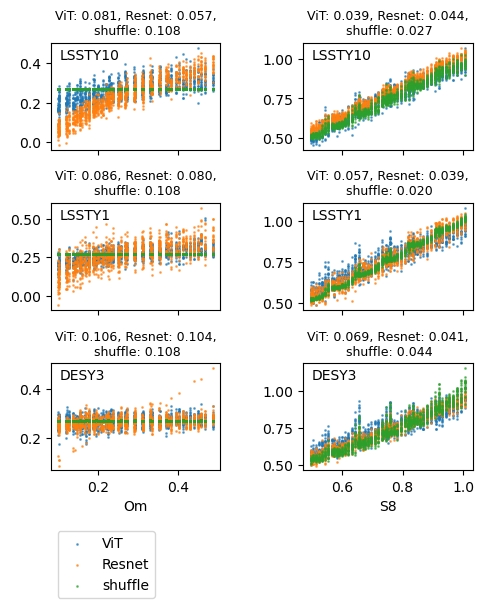

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(5, 6),sharex = 'col')  # 4x2 grid
fig.tight_layout(pad=6.0)

container_vit = np.load('CNN_container_vit.npy',allow_pickle=True).item()
container_resnet = np.load('CNN_container_resnet.npy',allow_pickle=True).item()
container_shuffle = np.load('CNN_container_shuffle.npy',allow_pickle=True).item()


labb =  ['LSSTY10','LSSTY1','DESY3']

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

for pp in [0,1]:
    for i,lab in enumerate(labb):
        ax = axes[i,pp]

        ax.scatter(container_vit[pp][lab]['params'],container_vit[pp][lab]['DATA'], alpha=0.6, label='ViT',s=1)
        ax.scatter(container_resnet[pp][lab]['params'],container_resnet[pp][lab]['DATA'], alpha=0.6, label='Resnet',s=1)
        ax.scatter(container_shuffle[pp][lab]['params'],container_shuffle[pp][lab]['DATA'], alpha=0.6, label='shuffle',s=1)

        # Calculate and annotate RMSE for Type1 and Type2
        rmse_val_type1 = rmse(container_vit[pp][lab]['params'],container_vit[pp][lab]['DATA'])
        rmse_val_type2 = rmse(container_resnet[pp][lab]['params'],container_resnet[pp][lab]['DATA'])
        rmse_val_type3 = rmse(container_shuffle[pp][lab]['params'],container_shuffle[pp][lab]['DATA'])
        rmse_annotation = f'ViT: {rmse_val_type1:.3f}, Resnet: {rmse_val_type2:.3f},\n shuffle: {rmse_val_type3:.3f}'
        ax.set_title(rmse_annotation, fontsize = 9)
        ax.annotate(lab, (0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10)

       # ax.set_title(f'Scatter Plot {i+1}')
        #ax.legend()

axes[2,0].legend(loc='upper left', bbox_to_anchor=(0, -0.5),ncol=1)
axes[2,0].set_xlabel('Om')
axes[2,1].set_xlabel('S8')
plt.tight_layout()
plt.show()

# LFI step

In [2]:
'''
I am using this environment to run LFI
/global/homes/m/mgatti/.conda/envs/bfd_env3
You should be able to install it in your jupyter as well
'''

'\nI am using this environment to run LFI\n/global/homes/m/mgatti/.conda/envs/bfd_env3\nYou should be able to install it in your jupyter as well\n'

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import pydelfi.priors as priors
import tensorflow as tf
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import emcee as mc
import numpy as np


def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'       

lower = np.array([0.15, 0.55])
upper = np.array([0.49, 0.99])
    
lower_mc = np.array([0.15, 0.55])
upper_mc = np.array([0.49, 0.99])
    
prior = priors.Uniform(lower, upper)


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
container_vit = np.load('CNN_container_vit.npy',allow_pickle=True).item()
container_resnet = np.load('CNN_container_resnet.npy',allow_pickle=True).item()
container_shuffle = np.load('CNN_container_shuffle.npy',allow_pickle=True).item()


In [3]:
def group_and_average(arr, labels, size = 4):
    out = arr.shape[1]
    unique_labels = np.unique(labels)
    result = []
    
    for label in unique_labels:
        # Filter the entries for the current label
        filtered_entries = arr[labels == label]
        
        # Calculate how many groups of size can be formed
        n_chunks = len(filtered_entries) // size
        
        # If there are not enough entries for at least one group, continue
        if n_chunks == 0:
            continue
        
        # Keep only the entries that can be grouped in fours
        filtered_entries = filtered_entries[:n_chunks * size]

        # Reshape to (-1, 4, out) and compute the mean along the new second axis
        averaged_entries = filtered_entries.reshape(-1, size, out).mean(axis=1)
        result.extend(averaged_entries)
    
    return np.array(result)


In [4]:
# prepare data
sizes = {'LSSTY10':4,'LSSTY1':3,'DESY3':1}

data = dict()
for network in ['ViT','resnet']:
    for label in ['LSSTY10','LSSTY1','DESY3']:
        
        data_ = np.vstack([container_vit[0][label]['DATA'],container_vit[1][label]['DATA']])
        labels_ = np.vstack([container_vit[0][label]['params'],container_vit[1][label]['params']])
        labels = np.array(['{0:2.4f}_{1:2.4f}'.format(labels_[0][i],labels_[1][i]) for i in range(labels_.shape[1])])
        
        
        target = np.mean(data_[:,labels == '0.2915_0.7723'],axis=1)
        
        r = group_and_average(np.vstack([data_,labels_]).T,labels,size = sizes[label])
        data_ = r[:,[0,1]]
        labels_ = r[:,[2,3]]
        
        
        
        data['{0}_{1}'.format(network,label)]  = [data_,labels_,target]
        
        
        
# add extra runs just to check the area scaling ---- 
         
    
data = dict()
for network in ['ViT','resnet']:
    for label in ['DESY3']:
        
        data_ = np.vstack([container_vit[0][label]['DATA'],container_vit[1][label]['DATA']])
        labels_ = np.vstack([container_vit[0][label]['params'],container_vit[1][label]['params']])
        labels = np.array(['{0:2.4f}_{1:2.4f}'.format(labels_[0][i],labels_[1][i]) for i in range(labels_.shape[1])])
        
        
        target = np.mean(data_[:,labels == '0.2915_0.7723'],axis=1)
        
        r = group_and_average(np.vstack([data_,labels_]).T,labels,size = 3)
        data_ = r[:,[0,1]]
        labels_ = r[:,[2,3]]
        
        label = label + '_LSSTY1_area'
        
        data['{0}_{1}'.format(network,label)]  = [data_,labels_,target]
        
      
    
    
        data_ = np.vstack([container_vit[0][label]['DATA'],container_vit[1][label]['DATA']])
        labels_ = np.vstack([container_vit[0][label]['params'],container_vit[1][label]['params']])
        labels = np.array(['{0:2.4f}_{1:2.4f}'.format(labels_[0][i],labels_[1][i]) for i in range(labels_.shape[1])])
        
        
        target = np.mean(data_[:,labels == '0.2915_0.7723'],axis=1)
        
        r = group_and_average(np.vstack([data_,labels_]).T,labels,size = 4)
        data_ = r[:,[0,1]]
        labels_ = r[:,[2,3]]
        
        label = label + '_LSSTY10_area'
        
        data['{0}_{1}'.format(network,label)]  = [data_,labels_,target]
        
        
        
        
        
        
        
data = dict()
for network in ['ViT','resnet']:
    for label in ['LSSTY10']:
        
        data_ = np.vstack([container_vit[0][label]['DATA'],container_vit[1][label]['DATA']])
        labels_ = np.vstack([container_vit[0][label]['params'],container_vit[1][label]['params']])
        labels = np.array(['{0:2.4f}_{1:2.4f}'.format(labels_[0][i],labels_[1][i]) for i in range(labels_.shape[1])])
        
        
        target = np.mean(data_[:,labels == '0.2915_0.7723'],axis=1)
        
        r = group_and_average(np.vstack([data_,labels_]).T,labels,size = 3)
        data_ = r[:,[0,1]]
        labels_ = r[:,[2,3]]
        
        label = label + '_LSSTY1_area'
        
        data['{0}_{1}'.format(network,label)]  = [data_,labels_,target]
        
      
    
    
        data_ = np.vstack([container_vit[0][label]['DATA'],container_vit[1][label]['DATA']])
        labels_ = np.vstack([container_vit[0][label]['params'],container_vit[1][label]['params']])
        labels = np.array(['{0:2.4f}_{1:2.4f}'.format(labels_[0][i],labels_[1][i]) for i in range(labels_.shape[1])])
        
        
        target = np.mean(data_[:,labels == '0.2915_0.7723'],axis=1)
        
        r = group_and_average(np.vstack([data_,labels_]).T,labels,size = 1)
        data_ = r[:,[0,1]]
        labels_ = r[:,[2,3]]
        
        label = label + '_DESY3_area'
        
        data['{0}_{1}'.format(network,label)]  = [data_,labels_,target]
        

In [6]:
DelfiEnsemble_dict = dict()
import getdist
from getdist import plots, MCSamples


theta2d_expected_mean = [ 0.3,0.75]
chains_dict = dict()

chains_dict = np.load('chains',allow_pickle=True).item()

count = 100
for key in data.keys():
    if not (key in chains_dict.keys()):
        print (key)
        DV = data[key][0]
        par =data[key][1]
        target = data[key][2]


        nn = len(lower)
        base = count # any time you re-run it, please increase this by the number of NDEs. Otherwise you'd need to restart the notebook.
        count += 4
        NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=DV.shape[1], n_hiddens=[60,60], n_mades=4, act_fun=tf.tanh, index=base + 0),#,
                ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=DV.shape[1], n_hiddens=[60,60], n_mades=5, act_fun=tf.tanh, index=base + 1),
                ndes.MixtureDensityNetwork(              n_parameters=nn, n_data=DV.shape[1], n_components=4, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 2),
                ndes.MixtureDensityNetwork(              n_parameters=nn, n_data=DV.shape[1], n_components=5, n_hidden=[60,60], activations=[tf.tanh, tf.tanh], index=base + 3)]


        pn = ['p{0}'.format(i) for i in range(nn)]


        import os
        try:
            os.mkdir(result_dir+'/'+str(base))
        except:
            pass
        try:
            os.system('rm '+result_dir+'/'+str(base)+'/*')
        except:
            pass

        DelfiEnsemble = delfi.Delfi(np.array(np.median(DV,axis=0), dtype = 'float'), prior, NDEs,
                                            param_limits = [lower, upper],
                                            param_names = pn, 
                                            results_dir = result_dir+'/'+str(base)+'/')
        #,False,False]

        DelfiEnsemble.load_simulations(np.array(DV,dtype = 'float'), par)
        DelfiEnsemble.train_ndes()
        DelfiEnsemble_dict['{0}'.format(key)] = DelfiEnsemble

        #





        n_dim2d=nn
        n_burn2d=1000
        n_steps2d = 10000
        n_walkers2d = nn * n_dim2d

        theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])



        def prior_term2d(theta2d):
            p_ = theta2d.T
            for i in range(len(p_)):
                if ((p_[i]<lower_mc[i])|(p_[i]>upper_mc[i])):
                    return  - np.inf
            return  0.



        def log_posterior2d_temp(theta2d, data):
            return DelfiEnsemble_dict['{0}'.format(key)].log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


       # sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(np.mean(compressed_DV[stat]['DV'],axis=0),))
        sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(target,))

        _ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

        final_chain = sampler2d_.get_chain()
        chains_dict['{0}'.format(key)] = final_chain




        tt = '{0}'.format(key)

        samples = MCSamples(samples=[chains_dict[tt][:,:,0].flatten(),chains_dict[tt][:,:,1].flatten()],
                            names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                            label=key,
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})


        fom = 1/np.sqrt(np.linalg.det(samples.cov()))
        print ('{0}'.format(key), fom)

np.save('chains',chains_dict)


Training:  15%|█▌        | 76/500 [00:36<00:44,  9.51it/s, train loss=-.27, val loss=-.0236]  

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//100/graph_checkpoint


Training:  21%|██        | 105/500 [00:42<00:37, 10.51it/s, train loss=-.37, val loss=0.353]  

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//100/graph_checkpoint


Training:  41%|████▏     | 207/500 [01:24<00:36,  8.06it/s, train loss=-.271, val loss=0.359]  

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//100/graph_checkpoint


Training:  33%|███▎      | 167/500 [01:26<00:43,  7.70it/s, train loss=-.228, val loss=0.405] 

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//100/graph_checkpoint


Training:  33%|███▎      | 167/500 [01:27<02:54,  1.91it/s, train loss=-.228, val loss=0.405]


Removed no burn in
ViT_LSSTY10 693.8173324693898


Training:   9%|▉         | 47/500 [00:37<01:24,  5.36it/s, train loss=0.511, val loss=1.42]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//104/graph_checkpoint


Training:  13%|█▎        | 66/500 [01:04<01:11,  6.11it/s, train loss=0.404, val loss=0.837]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//104/graph_checkpoint


Training:  20%|██        | 100/500 [01:36<01:07,  5.92it/s, train loss=0.55, val loss=0.884]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//104/graph_checkpoint


Training:  28%|██▊       | 139/500 [02:14<00:56,  6.43it/s, train loss=0.51, val loss=0.386] 

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//104/graph_checkpoint


Training:  28%|██▊       | 139/500 [02:16<05:53,  1.02it/s, train loss=0.51, val loss=0.386]


Removed no burn in
ViT_LSSTY1 418.2943997869101


Training:   9%|▉         | 44/500 [00:36<00:55,  8.24it/s, train loss=1.63, val loss=1.64]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//108/graph_checkpoint


Training:  12%|█▏        | 58/500 [00:45<00:44,  9.93it/s, train loss=1.63, val loss=1.64]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//108/graph_checkpoint


Training:  21%|██        | 106/500 [01:21<00:59,  6.67it/s, train loss=1.62, val loss=1.58]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//108/graph_checkpoint


Training:  27%|██▋       | 137/500 [04:47<09:56,  1.64s/it, train loss=-.12, val loss=-.00929]  

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//112/graph_checkpoint


Training:  27%|██▋       | 137/500 [04:50<12:49,  2.12s/it, train loss=-.12, val loss=-.00929]


Removed no burn in
resnet_LSSTY10 531.3914797049257


Training:  18%|█▊        | 92/500 [02:43<01:50,  3.68it/s, train loss=0.38, val loss=0.641] 

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//116/graph_checkpoint


Training:  12%|█▏        | 60/500 [02:07<02:52,  2.55it/s, train loss=0.436, val loss=1.18]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//116/graph_checkpoint


Training:   3%|▎         | 14/500 [01:06<34:59,  4.32s/it, train loss=1.85, val loss=1.79]

KeyboardInterrupt: 

Removed no burn in
ViT_DESY3 202.34569205670778
Removed no burn in
ViT_LSSTY1 418.1128600437307
Removed no burn in
ViT_LSSTY10 693.5865589292833


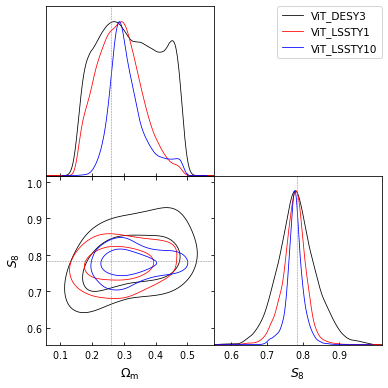

In [12]:
ss = []
xx = 100
g = plots.getSubplotPlotter(width_inch=5.5)

#for tt in ['VMIM_WL_23','MOPED_WL_23','VMIM_WL_2','MOPED_WL_2']:
#for tt in ['MOPED_full_WL_23_WPH_WCMBL_CMBL','MOPED_full_WL_23_WPH_WCMBL','MOPED_full_WL_23_WPH','MOPED_full_WL_2']:#,'MOPED_WL_2']:
for tt in ['ViT_DESY3','ViT_LSSTY1','ViT_LSSTY10']:

    samples = MCSamples(samples=[chains_dict[tt][xx:,:,0].flatten(),chains_dict[tt][xx:,:,1].flatten()],
                            names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                            label=tt,
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.6, 'smooth_scale_1D':0.2})

    fom = 1/np.sqrt(np.linalg.det(samples.cov()))
    print (tt, fom)
            
    ss.append(samples)
g.triangle_plot(ss,['Om','s8'],legend_loc='upper right' ,markers = [0.26,0.84*np.sqrt(0.26/0.3)]) #,shaded=True)
plt.show()